# Methods for Data Science (MATH70026)
## Coursework 2
### Amaury Francou - CID : 01258326
#### amaury.francou16@imperial.ac.uk

<a name="outline"></a>

## Outline

- [Task 1](#task-1): Neural networks
  - [1.1](#q11) Multi-layer perceptron
  - [1.2](#q12) Convolutional neural network (CNN)
- [Task 2](#task-2): Unsupervised learning
  - [2.1](#q21) Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data
  - [2.2](#q22) Clustering of the feature matrix
  - [2.3](#q23) Graph-based analysis 
- [Task 3](#task-3): Mastery component 
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for dimensionality reduction 
  - [3.2](#q32) Community detection


In [23]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D
from keras import models

from scipy.sparse import linalg
import scipy

import pandas as pd 

import networkx as nx

from sklearn.metrics.cluster import adjusted_rand_score

<a name="task-1"></a>
# Task 1: Neural networks [^](#outline)

We here implement a Multi-Layer Perceptron (MLP) and a convolutional neural network (CNN) to perform a classification task on images. We are provided with the Fashion-MNIST dataset, composed of 60 000 images for the training set and 10 000 images for the testing set. There are 10 classes. Both the training and testing set are well balanced regarding said classes.

We start by loading are data as $\texttt{numpy}$ arrays. 

In [401]:
### Provided data-loading method ###

def load_data():
    
 (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
 x_train = x_train.astype('float32') / 255
 x_test = x_test.astype('float32') / 255

 # convert labels to categorical samples
 y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
 y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    
 return ((x_train, y_train), (x_test, y_test))

print('Downloading data')
(x_train, y_train), (x_test, y_test) = load_data()
print('End of download')

# Visualizing the data
print('')
print('Training set shape : ', y_train.shape)
print('Testing set shape : ', y_test.shape)
print('')
print('Training sample : ')
print('Image of size : ', x_train[100,:].shape)
print('Class :',y_train[100,:])


End of download

Training set shape :  (60000, 10)
Testing set shape :  (10000, 10)

Training sample : 
Image of size :  (28, 28)
Class : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<a name="q11"></a>

## 1.1 Multi-layer perceptron [^](#outline)

We implement the MLP using the $\texttt{numpy}$ library. The network will be composed of one 784-neurons input layer (28$\times$ 28 pixels for the images), five 400-neurons hidden layers, and one 10-neurons output layer (one neuron for each class). The activation function between all layers will be the $\texttt{LeakyReLU}$ function, except for the output layer which will use a softmax function as activation. The loss function will be cross-entropy, and the optimisation of the network parameters will be made using stochastic gradient descent.

We implement several helper functions to perform this task. 

In [402]:
def softmax(x) :
    """
    This function computes the softmax function applied element-wise on the x vector. 

    Parameters
    ----------
    x : an N-dimensional numpy array - the pre-activations of the output layer

    Returns
    -------
    exps : an N-dimensional numpy array - the activations of the output layer
    """
    
    # Exponential element-wise
    expx = np.exp(x - x.max()) # We substract the maximum to avoid having overflow later in the process 
    
    return expx / np.sum(expx)

The $\texttt{LeakyReLU}$ function is such that $\texttt{LeakyReLU}(x) = x \text{ if } x \geq 0 \text{, or } \alpha x \text{ otherwise}$. 

In [403]:
def leakyReLU(x, alpha = 1e-2) :
    """
    This function computes the LeakyReLU function applied element-wise on the x vector. 

    Parameters
    ----------
    x : an N-dimensional numpy array - the pre-activations of the inner layers
    alpha : a float scalar - the function slope on the negative values of x

    Returns
    -------
    ReLUx : an N-dimensional numpy array - the activations of the inner layers
    """
    
    N = x.shape[0] # Shape of vector x
    ReLUx = 1.0 * x # Initialization of output vector
    
    ReLUx[ReLUx < 0] *= alpha # By definition
    
    return ReLUx

We define a function that initializes our MLP model, using a dictionnary to store its parameters. The weights are initialized randomly and bias values set to zero. 

In [406]:
def initializeMLP(inputLayerSize = 784, innerLayerSize = 400, outputLayerSize = 10) :
    """
    This function initializes our MLP model. 

    Parameters
    ----------
    inputLayerSize : an integer - the number of neurons in the input layer
    innerLayerSize : an integer - the number of neurons in the inner layers
    outputLayerSize : an integer - the number of neurons in the output layer

    Returns
    -------
    MLP : a dictionnary - containing the parameters of our model
    """
    
    MLP = {} # Initializing our model
    
    # Computing those parameters only once
    # We use Xavier's initialization by dividing our randomly drawn weights by the following parameters
    inputLayerSizeSQRT = np.sqrt(inputLayerSize)
    innerLayerSizeSQRT = np.sqrt(innerLayerSize)
    
    # Input layer
    MLP['INto1'] = {}
    MLP['INto1']['W'] = np.random.randn(innerLayerSize,inputLayerSize) / inputLayerSizeSQRT # Weights randomly set
    MLP['INto1']['b'] = np.zeros(innerLayerSize) # Bias set to zero
    
    # Inner layers
    for k in range(1,5) : # 5 inner layers give 4 connections between layers 
        MLP[str(k) + 'to' + str(k+1)] = {}
        MLP[str(k) + 'to' + str(k+1)]['W'] = np.random.randn(innerLayerSize,innerLayerSize)\
            / innerLayerSizeSQRT # Weights
        MLP[str(k) + 'to' + str(k+1)]['b'] = np.zeros(innerLayerSize) # Bias
        
    # Output layer
    MLP['5toOUT'] = {}
    MLP['5toOUT']['W'] = np.random.randn(outputLayerSize,innerLayerSize) / innerLayerSizeSQRT # Weights
    MLP['5toOUT']['b'] = np.zeros(outputLayerSize) # Bias
        
    return MLP

In [407]:
MLP = initializeMLP()
# Testing
print('Our model :')
print(MLP.keys())
print(MLP['1to2'].keys())
print('Sample of weights :')
print(MLP['1to2']['W'][10:15,10:15])

Our model :
dict_keys(['INto1', '1to2', '2to3', '3to4', '4to5', '5toOUT'])
dict_keys(['W', 'b'])
Sample of weights :
[[ 0.03786403 -0.01080714  0.05340781  0.15478476 -0.05941266]
 [ 0.01307988  0.01362654 -0.05064149  0.08673938  0.03599058]
 [ 0.01968021  0.05342433  0.00707878  0.03287149 -0.02692897]
 [ 0.14260403 -0.06748869 -0.0161117   0.03089596  0.02099248]
 [-0.01795096  0.06564406 -0.01804795 -0.04400125 -0.00222618]]


In order to perform the backpropagation process, we need to perform a forward pass through the model while storing the values of the pre and post activations. We implement a function to perform this task, again using a dictionnary.

The pre-activations are given by $\mathbf{a}^{(k)} = \mathbf{W}^{(k)} \mathbf{h}^{(k-1)} + \mathbf{b}^{(k)}
$, where $\mathbf{W}^{(k)} \in \mathbb{R}^{ n_{k-1} \times n_k }$ are the weights set between layers $k-1$ and $k$, and where $\mathbf{b}^{(k)} \in \mathbb{R}^{n_k}$ are the bias values set between the same layers.

The post-activations are such that $\mathbf{h}^{(k)} = \sigma(\mathbf{a}^{(k)})$, where $\sigma$ is the activation function.

In [408]:
def propagate(x, MLP = MLP, alpha = 1e-2) :
    """
    This function computes the pre and post activations using a forward pass through the model. 

    Parameters
    ----------
    x : an N-dimensional numpy array - our input image flatten into a vector  
    MLP : a dictionnary - our MLP model
    alpha : a float scalar - the leakyReLU slope on the negative values of x

    Returns
    -------
    propParams : a dictionnary - containing the pre and post activations related to x
    """
    
    propParams = {}  # Initializing our output
    
    # First inner layer
    propParams['layer1'] = {}
    propParams['layer1']['a'] = MLP['INto1']['W']@x + MLP['INto1']['b']
    propParams['layer1']['h'] = leakyReLU(propParams['layer1']['a'], alpha = alpha)
    
    # Inner layers 
    for k in range(2,6) :
        propParams['layer' + str(k)] = {}
        propParams['layer' + str(k)]['a'] = MLP[str(k-1) + 'to' + str(k)]['W']@ \
            propParams['layer' + str(k-1)]['h'] + MLP[str(k-1) + 'to' + str(k)]['b']
        propParams['layer' + str(k)]['h'] = leakyReLU(propParams['layer' + str(k)]['a'], alpha = alpha)
        
    # Output layer 
    propParams['outputLayer'] = {}
    propParams['outputLayer']['a'] = MLP['5toOUT']['W']@propParams['layer5']['h'] + \
        MLP['5toOUT']['b']
    propParams['outputLayer']['h'] = softmax(propParams['outputLayer']['a'])
    
    
    return propParams

In [409]:
# Testing forward pass
propTest = propagate(x = x_train[10,:,:].flatten())
print('Propagation data structure :')
print(propTest.keys())
print(propTest['layer1'].keys())
print('Sample of pre-activations :')
print(propTest['layer1']['a'][10:20])

Propagation data structure :
dict_keys(['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'outputLayer'])
dict_keys(['a', 'h'])
Sample of pre-activations :
[ 0.28902648 -0.05352926  0.06125141  0.52065527  0.14248869  0.25432872
  0.46134131 -0.39862411 -0.41826434  0.13241137]


We use categorical cross-entropy as our loss function. Namely, for one training sample $x^{(i)}$, having value $y^{(i)}$, and being precited to $\hat{y}^{(i)}$, the per-example cross-entropy loss reads $L_i = -\sum_k y_k^{(i)} \log(\hat{y}_k^{(i)})$, where index $k$ refers to the 10 given classes.

We start by computing the quantity $\delta^{(L+1)}_j = \frac{\partial L_i}{\partial \mathbf{a}_j^{(L+1)}}$ on the output neurons. By using the chain rule : $\frac{\partial L_i}{\partial \mathbf{a}_j^{(L+1)}} = \sum_k \frac{\partial L_i}{\partial \hat{y}_k^{(i)}} \frac{\partial \hat{y}_k^{(i)}}{\partial \mathbf{a}_j^{(L+1)} } = -y_j^{(i)}(1-\hat{y}_j^{(i)}) + \sum_{k\neq j}y_k^{(i)}\hat{y}_j^{(i)} = \hat{y}_j^{(i)} - y_j^{(i)}$.

We backpropagate the errors to compute all $\delta^{(k)}$, using the following update : $\delta^{(k)} = \sigma'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T\delta^{(k+1)}$, where $\sigma'$ is the derivative of the activation function.

We finally obtain $\frac{\partial L_i}{\partial w_{pq}^{(k)}} = \delta_p^{(k+1)} h_q^{(k)}$ and $\frac{\partial L_i}{\partial b_{p}^{(k)}} = \delta_p^{(k+1)}$.

We implement a backpropagation method computing the gradient of the per-example loss function.

In [410]:
def leakyReLUPrime(x, alpha = 1e-2) :
    """
    This function computes the LeakyReLU function derivative 
        applied element-wise on the x vector. 

    Parameters
    ----------
    x : an N-dimensional numpy array - the pre-activations of the inner layers
    alpha : a float scalar - the function slope on the negative values of x

    Returns
    -------
    ReLUPrimex : an N-dimensional numpy array - the derivative of the LeakyReLU function
        applied on the values in x
    """
    
    N = x.shape[0] # Shape of vector x
    ReLUPrimex = np.ones(N) # Initialization of output vector
    
    ReLUPrimex[x < 0] = alpha
            
    return ReLUPrimex

In [411]:
def backpropagate(x, y, MLP = MLP, alpha = 1e-2) :
    """
    This function computes a backpropagation pass using sample image x having class y. It computes
    the gradient of the loss function regarding the model parameters.

    Parameters
    ----------
    x : an N-dimensional numpy array - our input image flatten into a vector  
    y : an M-dimensional numpy array - the image's corresponding serialized class 
    MLP : a dictionnary - our MLP model
    alpha : a float scalar - the leakyReLU slope on the negative values of x

    Returns
    -------
    gradParams : a dictionnary - the gradient of the loss function with respect to the model parameters
    """
    
    propParams = propagate(x, MLP = MLP) # Getting pre and post activations
    y_predict = propParams['outputLayer']['h'] # Prediction made for x
    
    gradParams = {} # Initializing 
    
    # Layer 5 to Output layer 
    gradParams['5toOUT'] = {}
    delta = y_predict - y # Deltas
    h = propParams['layer5']['h'] # Activations
    gradParams['5toOUT']['dW'] = np.outer(delta,h) # As in formula
    gradParams['5toOUT']['db'] = delta # As in formula
    
    # Layer 4 to 5
    gradParams['4to5'] = {}
    delta = np.multiply(leakyReLUPrime(x = propParams['layer5']['a'], alpha = alpha), \
            (MLP['5toOUT']['W'].T @ delta))
    h = propParams['layer4']['h']
    gradParams['4to5']['dW'] = np.outer(delta,h) # As in formula
    gradParams['4to5']['db'] = delta # As in formula
    
    # Inner layers
    for k in reversed(range(1,4)) :
        gradParams[str(k) + 'to' + str(k+1)] = {}
        delta = np.multiply(leakyReLUPrime(x = propParams['layer' + str(k+1)]['a'], alpha = alpha), \
            (MLP[str(k+1) + 'to' + str(k+2)]['W'].T @ delta))
        h = propParams['layer' + str(k)]['h']
        gradParams[str(k) + 'to' + str(k+1)]['dW'] = np.outer(delta, h)
        gradParams[str(k) + 'to' + str(k+1)]['db'] = delta
    
    # Input layer to 1
    gradParams['INto1'] = {}
    delta = np.multiply(leakyReLUPrime(x = propParams['layer1']['a'], alpha = alpha), \
            (MLP['1to2']['W'].T @ delta))
    h = x
    gradParams['INto1']['dW'] = np.outer(delta, h)
    gradParams['INto1']['db'] = delta
    
    return gradParams

In [412]:
# Testing backward propagation 
backPropTest = backpropagate(x = x_train[10,:,:].flatten(), y = y_train[10])
print('Back Propagation data structure :')
print(backPropTest.keys())
print(backPropTest['INto1'].keys())
print('Sample of loss function gradient :')
print(backPropTest['2to3']['dW'][10:15,10:15])

Back Propagation data structure :
dict_keys(['5toOUT', '4to5', '3to4', '2to3', '1to2', 'INto1'])
dict_keys(['dW', 'db'])
Sample of loss function gradient :
[[ 1.50144071e-04  1.02962515e-04  4.11177704e-05 -1.07736558e-06
  -8.95461459e-07]
 [ 1.22356252e-02  8.39067925e-03  3.35079250e-03 -8.77972820e-05
  -7.29734493e-05]
 [-1.28784616e-02 -8.83150956e-03 -3.52683676e-03  9.24099841e-05
   7.68073354e-05]
 [ 8.12895992e-03  5.57450023e-03  2.22615989e-03 -5.83297198e-05
  -4.84812371e-05]
 [ 7.41922040e-03  5.08779059e-03  2.03179386e-03 -5.32369517e-05
  -4.42483401e-05]]


We perform the stochastic gradient descent on batches of 256 data points. We implement a batch-building function. 

In [413]:
def buildBatches(xData, yData, batchSize = 256) :
    """
    This function computes batches of data points used for the stochastic gradient descent, in the
    training of our model.

    Parameters
    ----------
    xData : an NxlxL-dimensional numpy array - our input images  
    yData : an NxM-dimensional numpy array - the images' corresponding serialized classes
    batchSize : an integer - the batch size

    Returns
    -------
    batches : an KxPxQ-dimensional numpy array - containing our batches of data points
    """
    
    # Building array containing stacked and flatten data
    
    nbDataPoints = yData.shape[0] # Number of data points
    nbClasses = yData.shape[1] # Number of classes
    imageSize = x_train[0,:].shape[0] * x_train[0,:].shape[1] # Size of flatten image
    
    dataArray = np.zeros((nbDataPoints,imageSize + nbClasses)) # Initializing array with x and y stacked
    
    for i in range(nbDataPoints) :
        dataArray[i,:imageSize] = x_train[i,:,:].flatten()
        dataArray[i,imageSize:] = y_train[i]
    
    # Shuffling data
    np.random.shuffle(dataArray) 
    
    nbBatches = nbDataPoints // batchSize # Number of batches | Some data points are dropped 
    
    batches = [] # Initializing batch list
    for k in range(nbBatches):
        batches += [dataArray[k * batchSize :(k+1) * batchSize]]
        
    batches = np.array(batches) # Size nbBatches x batchSize x (imageSize + nbClasses)
    
    return batches

In [414]:
# Testing batch building
testBatchesArray = buildBatches(xData = x_train, yData = y_train, batchSize = 256)
print('Our batches array dimension : ', testBatchesArray.shape)

Our batches array dimension :  (234, 256, 794)


We compute the gradient of the loss function over one batch $\mathcal{B}$ composed of $M=256$ data points : $\nabla L = \frac{1}{M} \sum_{y^{(i)},\hat{y}^{(i)}\in\mathcal{B}} \nabla L_i$. The per-sample quantity $\nabla L_i$ is computed using backpropagation. We implement a function for computing the overall gradient.

In [415]:
def gradL(batch, imageSize = 784, MLP = MLP, alpha = 1e-2) :
    """
    This function computes the gradient of the loss function on one given batch of data points.

    Parameters
    ----------
    batch : an PxQ-dimensional numpy array - one batch of data points 
    imageSize : an integer - the flatten image size
    MLP : a dictionnary - our MLP model
    alpha : a float scalar - the leakyReLU slope on the negative values of x

    Returns
    -------
    avgGradParams : a dictionnary - containing the gradient of the loss function
    """
    
    batchSize = batch.shape[0] # Retreiving batch size
    
    x = batch[0,:imageSize]
    y = batch[0,imageSize:]
    avgGradParams = backpropagate(x = x, y = y, MLP = MLP, alpha = alpha)  # Initializing
    
    for i in range(1,batchSize) :
        x = batch[i,:imageSize]
        y = batch[i,imageSize:] 
        gradParams = backpropagate(x = x, y = y, MLP = MLP, alpha = alpha)  # Backpropagation
        for key1 in gradParams.keys() :
            for key2 in gradParams[key1].keys() :
                avgGradParams[key1][key2] += gradParams[key1][key2] # Sum dW and dB to aggregate
            
    for key1 in avgGradParams.keys() :
        for key2 in avgGradParams[key1].keys() :
            avgGradParams[key1][key2] /= batchSize # Mean 
        
    return avgGradParams

In [416]:
# Testing gradient computation
testGradL = gradL(batch = testBatchesArray[0])
print('Gradient data structure :')
print(testGradL.keys())

Gradient data structure :
dict_keys(['5toOUT', '4to5', '3to4', '2to3', '1to2', 'INto1'])


We implement accuracy and loss functions over all the dataset to further assess the performance of our model.

In [417]:
def lossFunction(xData, yData, MLP = MLP, alpha = 1e-2) :
    """
    This function computes the loss function on the given set of data points.

    Parameters
    ----------
    xData : an NxlxL-dimensional numpy array - our input images  
    yData : an NxM-dimensional numpy array - the images' corresponding serialized classes
    MLP : a dictionnary - our MLP model
    alpha : a float scalar - the leakyReLU slope on the negative values of x

    Returns
    -------
    L : a float number - the value of the loss function
    """
    
    nbDataPoints = yData.shape[0] # Number of data points
    nbClasses = yData.shape[1] # Number of classes
    
    L = 0 # Initializing count
    
    for i in range(nbDataPoints) :
        y_predict = propagate(x = xData[i,:,:].flatten(), \
                              MLP = MLP, alpha = alpha)['outputLayer']['h'] # Prediction made for x
        L += -1.0 * np.sum(np.multiply(yData[i],np.log(y_predict + 1e-14))) # Adding 10^-14 to avoid having log(0)
        
    L /= nbDataPoints # Mean
    
    return L

In [418]:
# Loss on full training set with random weights and bias 
lossTest = lossFunction(xData = x_train, yData = y_train)
print('L = ', lossTest)

L =  2.3046732064758455


In [419]:
def accuracy(xData, yData, MLP = MLP, alpha = 1e-2) :
    """
    This function computes the accuracy of the model on the given set of data points.

    Parameters
    ----------
    xData : an NxlxL-dimensional numpy array - our input images  
    yData : an NxM-dimensional numpy array - the images' corresponding serialized classes
    MLP : a dictionnary - our MLP model
    alpha : a float scalar - the leakyReLU slope on the negative values of x

    Returns
    -------
    A : a float number - the value of the accuracy
    """
    
    nbDataPoints = yData.shape[0] # Number of data points
    
    A = 0 # Initializing count
    
    for i in range(nbDataPoints) :
        y_predict = propagate(x = xData[i,:,:].flatten(), \
                        MLP = MLP, alpha = alpha)['outputLayer']['h'] # Prediction made for x
        classPredicted = np.argmax(y_predict) # Index of class predicted 
        classTruth = np.argmax(yData[i]) # Index of ground truth class
        
        if classPredicted == classTruth :
            A += 1
            
    A /= nbDataPoints # Mean
    
    return A

In [420]:
# Accuracy on full training set with random weights and bias 
MLP = initializeMLP()
accTest = accuracy(x_train, y_train, MLP)
print('accuracy = ', accTest)

accuracy =  0.15175


We now have all the building blocks to implement the training function for our MLP model. 

In [421]:
def trainMLP(x_train, y_train, x_test, y_test, epochs = 10, \
             learningRate = 1e-2, alpha = 1e-2) :
    """
    This function computes the model's training, using stochastic gradient descent on the training
    data points, and provides relevant metrics.

    Parameters
    ----------
    x_train : an NxlxL-dimensional numpy array - our input images of the training set  
    y_train : an NxM-dimensional numpy array - the images' corresponding serialized classes of the training set 
    x_test : an N'xlxL-dimensional numpy array - our input images of the testing set  
    y_train : an N'xM-dimensional numpy array - the images' corresponding serialized classes of the testing set  
    epochs : an integer - the number of epochs
    learningRate : a float number - the gradient descent learning rate coefficient 
    alpha : a float scalar - the leakyReLU slope on the negative values of x

    Returns
    -------
    MLP : a dictionnary - our MLP model
    trainLoss : a D-dimensional numpy array - containing the loss function value computed over 
        the training set for all epochs
    testLoss : a D-dimensional numpy array - containing the loss function value computed over 
        the testing set for all epochs
    trainAcc : a D-dimensional numpy array - containing the accuracy value computed over 
        the training set for all epochs
    testingAcc : a D-dimensional numpy array - containing the accuracy value computed over 
        the testing set for all epochs
    """
    
    # Initializing MLP
    MLP = initializeMLP()
    
    # Initializing metrics arrays
    trainLoss = np.zeros(epochs + 1)
    trainAcc = np.zeros(epochs + 1)
    testLoss = np.zeros(epochs + 1)
    testAcc = np.zeros(epochs + 1)
    
    # Computing metrics on full sets with random weights and bias 
    trainLoss[0] = lossFunction(xData = x_train, yData = y_train, MLP = MLP, alpha = alpha) 
    trainAcc[0] = accuracy(xData = x_train, yData = y_train, MLP = MLP, alpha = alpha) 
    testLoss[0] = lossFunction(xData = x_test, yData = y_test, MLP = MLP, alpha = alpha) 
    testAcc[0] = accuracy(xData = x_test, yData = y_test, MLP = MLP, alpha = alpha) 
    
    # Prints
    printings = 'Pre-training computations completed | Train Loss = ' + str(trainLoss[0] ) + \
            ' | Train Accuracy = ' + str(trainAcc[0]) + ' | Test Loss = ' + str(testLoss[0]) + \
        ' | Test Accuracy = ' + str(testAcc[0])
    print(printings)
    
    # Building random batches on training data
    batches = buildBatches(xData = x_train, yData = y_train, batchSize = 256)
    
    print('Starting the training')
    
    for N in range(epochs) : # Going through epochs | Master loop
        
        for batch in batches : # Going through batches
            
            # Computing gradient 
            avgGradParams = gradL(batch, imageSize = 784, MLP = MLP, alpha = alpha) 
            
            for key1 in MLP.keys() :
                for key2 in MLP[key1].keys() :
                    # Gradient descent
                    MLP[key1][key2] = MLP[key1][key2] - learningRate * avgGradParams[key1]['d' + key2]

        # Computing metrics
        trainLoss[N + 1] = lossFunction(xData = x_train, yData = y_train, MLP = MLP, alpha = alpha) 
        trainAcc[N + 1] = accuracy(xData = x_train, yData = y_train, MLP = MLP, alpha = alpha) 
        testLoss[N + 1] = lossFunction(xData = x_test, yData = y_test, MLP = MLP, alpha = alpha) 
        testAcc[N + 1] = accuracy(xData = x_test, yData = y_test, MLP = MLP, alpha = alpha) 
        
        # Prints
        printings = 'Epoch N = ' + str(N+1) + ' completed | Train Loss = ' + str(trainLoss[N + 1] ) + \
            ' | Train Accuracy = ' + str(trainAcc[N + 1]) + ' | Test Loss = ' + str(testLoss[N + 1]) + \
        ' | Test Accuracy = ' + str(testAcc[N + 1])
        
        print(printings)
        
    print('End of training')
        
    return MLP, trainLoss, trainAcc, testLoss, testAcc

### 1.1.1 

We now perform the training of our MLP model on batches of 256 data points, with a learning rate of $10^{-3}$, on 40 epochs. We assess the loss function and the accuracy of said model, on both training and validation data, for each number of epochs computed. 

In [423]:
###################################################################################################################

In [424]:
###################################################################################################################

In [422]:
###################################################################################################################
### DO NOT RUN AGAIN ###
t1 = time.time()
MLP111, trainLoss111, trainAcc111, testLoss111, testAcc111 = trainMLP(x_train, y_train, \
                                                                      x_test, y_test, epochs = 40, \
             learningRate = 1e-3, alpha = 1e-2)
t2 = time.time()
print('Wall time = ', t2 - t1)
### DO NOT RUN AGAIN ###
###################################################################################################################

Pre-training computations completed | Train Loss = 2.29816589138636 | Train Accuracy = 0.10268333333333333 | Test Loss = 2.2978578236886666 | Test Accuracy = 0.1029
Starting the training
Epoch N = 1 completed | Train Loss = 2.2627441172422618 | Train Accuracy = 0.23811666666666667 | Test Loss = 2.262585641875143 | Test Accuracy = 0.2342
Epoch N = 2 completed | Train Loss = 2.220818092222164 | Train Accuracy = 0.26511666666666667 | Test Loss = 2.220670211575046 | Test Accuracy = 0.2625
Epoch N = 3 completed | Train Loss = 2.1669573743377955 | Train Accuracy = 0.28905 | Test Loss = 2.166937265237185 | Test Accuracy = 0.2889
Epoch N = 4 completed | Train Loss = 2.096538017732176 | Train Accuracy = 0.35231666666666667 | Test Loss = 2.096848219818527 | Test Accuracy = 0.3494
Epoch N = 5 completed | Train Loss = 2.0013779415583133 | Train Accuracy = 0.42228333333333334 | Test Loss = 2.00220573302967 | Test Accuracy = 0.4172
Epoch N = 6 completed | Train Loss = 1.8726825885892193 | Train Accu

In [425]:
###################################################################################################################

In [426]:
###################################################################################################################

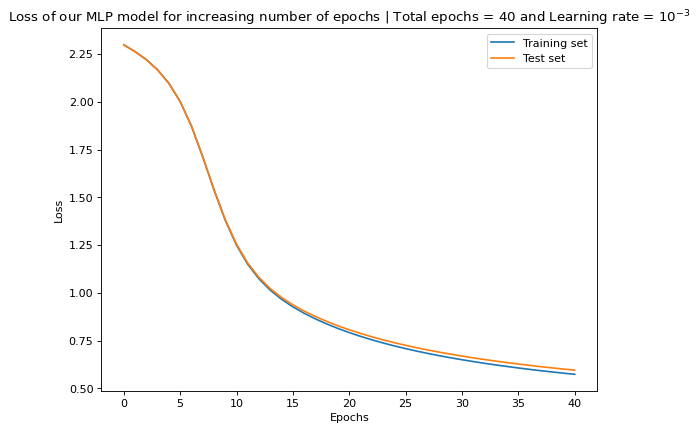

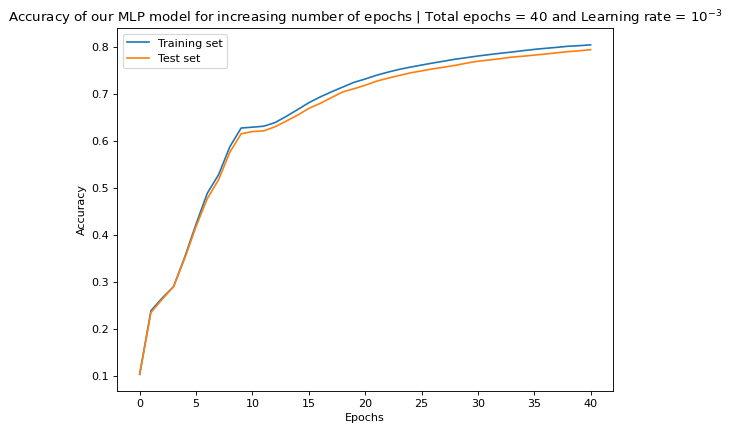

In [452]:
EPOCHS = np.array([N for N in range(41)])

# Loss
plt.figure(figsize=(8, 6), dpi=80)
title = 'Loss of our MLP model for increasing number of epochs | Total epochs = 40 and Learning rate = $10^{-3}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(EPOCHS, trainLoss111, label = 'Training set')
plt.plot(EPOCHS, testLoss111, label = 'Test set')
plt.legend(loc = 'best')

# Accuracy
plt.figure(figsize=(8, 6), dpi=80)
title = 'Accuracy of our MLP model for increasing number of epochs | \
Total epochs = 40 and Learning rate = $10^{-3}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(EPOCHS, trainAcc111, label = 'Training set')
plt.plot(EPOCHS, testAcc111, label = 'Test set')
plt.legend(loc = 'best')

We observe that the loss decreases continuously as the number of epochs grows, for both the training and the testing set. This decrease slows down for higher epochs, converging to a minimal value. Unsurprisingly, the test set loss is always slighlty higher than the training set loss, highlighting a good generalisability of the model for those numbers of epochs.  

In the same way, the accuracy continuously grows for both the training and the testing set, converging to roughly 80%. The test set accuracy is slighlty lower than the training set accuracy, although staying fairly close and not displaying any overfitting for a total number of epochs smaller than 40. As the accuracy obtained here may not prove usable in practice (20% of misclassification), one may consider upgrading the model's complexity, for instance adding more hidden layers, in order to improve said metrics. 

### 1.1.2

We now perform the training of our MLP model, again on batches of 256 data points, however this time using two different learning rates $10^{-5}$ and $10^{-1}$, still over 40 epochs. We assess the loss function and the accuracy of said model, on both training and validation data, for each number of epochs computed, and further compare them with our previous results. 

In [427]:
###################################################################################################################

In [428]:
###################################################################################################################

In [443]:
###################################################################################################################
### DO NOT RUN AGAIN ###
t1 = time.time()
MLP112i, trainLoss112i, trainAcc112i, testLoss112i, testAcc112i = trainMLP(x_train, y_train, \
                                                                      x_test, y_test, epochs = 40, \
             learningRate = 1e-5, alpha = 1e-2)
t2 = time.time()
print('Wall time = ', t2 - t1)
### DO NOT RUN AGAIN ###
###################################################################################################################

Pre-training computations completed | Train Loss = 2.308847444882454 | Train Accuracy = 0.0738 | Test Loss = 2.308962287702194 | Test Accuracy = 0.0737
Starting the training
Epoch N = 1 completed | Train Loss = 2.3083878719350666 | Train Accuracy = 0.07503333333333333 | Test Loss = 2.3085055608267915 | Test Accuracy = 0.0749
Epoch N = 2 completed | Train Loss = 2.307929119232667 | Train Accuracy = 0.07633333333333334 | Test Loss = 2.3080497131035376 | Test Accuracy = 0.0763
Epoch N = 3 completed | Train Loss = 2.3074711420524 | Train Accuracy = 0.07758333333333334 | Test Loss = 2.3075947517760005 | Test Accuracy = 0.0783
Epoch N = 4 completed | Train Loss = 2.307014029156637 | Train Accuracy = 0.079 | Test Loss = 2.3071405988107854 | Test Accuracy = 0.0794
Epoch N = 5 completed | Train Loss = 2.3065574970347207 | Train Accuracy = 0.08068333333333333 | Test Loss = 2.306686973043507 | Test Accuracy = 0.0812
Epoch N = 6 completed | Train Loss = 2.306101855480276 | Train Accuracy = 0.08241

In [429]:
###################################################################################################################

In [430]:
###################################################################################################################

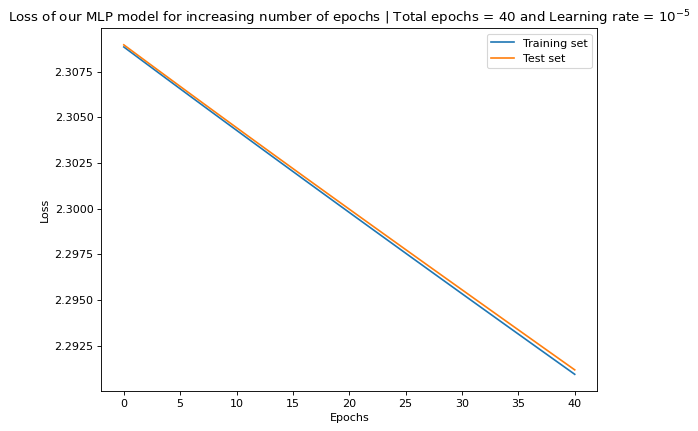

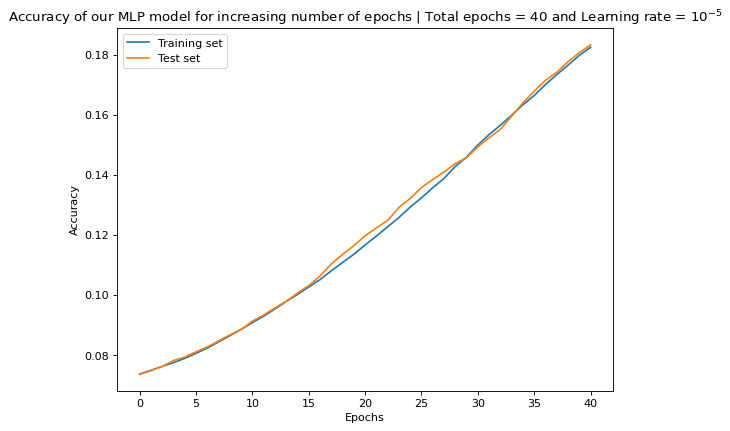

In [453]:
# Loss
plt.figure(figsize=(8, 6), dpi=80)
title = 'Loss of our MLP model for increasing number of epochs | Total epochs = 40 and Learning rate = $10^{-5}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(EPOCHS, trainLoss112i, label = 'Training set')
plt.plot(EPOCHS, testLoss112i, label = 'Test set')
plt.legend(loc = 'best')

# Accuracy
plt.figure(figsize=(8, 6), dpi=80)
title = 'Accuracy of our MLP model for increasing number of epochs | \
Total epochs = 40 and Learning rate = $10^{-5}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(EPOCHS, trainAcc112i, label = 'Training set')
plt.plot(EPOCHS, testAcc112i, label = 'Test set')
plt.legend(loc = 'best')

We observe that both the loss decreases and the accuracy increases continuously as the number of epochs grows, for both the training and the testing set. The testing metrics stay close to the training ones, not displaying any overfitting for those numbers of epochs.

The model has here been trained with a fairly small learning rate ($10^{-5}$), which results in very slow convergence to optimum parameters and thus very slow convergence to minimum loss and maximum accuracy. The learning rate is the step size with which the gradient descent is performed. Hence, a smaller step size requires more epochs to converge towards the desired minimum, and thus higher computation times. Moreover, a learning rate chosen too small may lead to a stagnating suboptimal result if a plateau is reached in the optimisation path. 

In this setting, the loss reaches roughly 2.29 and the accuracy 18% after 40 epochs, displaying the slow convergence rate. In comparison, for a learning rate of $10^{-3}$, we reached a loss of 0.6 and an accuracy 80% after the same number of epochs. 

In [431]:
###################################################################################################################

In [432]:
###################################################################################################################

In [444]:
###################################################################################################################
### DO NOT RUN AGAIN ###
t1 = time.time()
MLP112ii, trainLoss112ii, trainAcc112ii, testLoss112ii, testAcc112ii = trainMLP(x_train, y_train, \
                                                                      x_test, y_test, epochs = 40, \
             learningRate = 1e-1, alpha = 1e-2)
t2 = time.time()
print('Wall time = ', t2 - t1)
### DO NOT RUN AGAIN ###
###################################################################################################################

Pre-training computations completed | Train Loss = 2.296230972572626 | Train Accuracy = 0.12735 | Test Loss = 2.2960969794900774 | Test Accuracy = 0.13
Starting the training
Epoch N = 1 completed | Train Loss = 0.5696589864405318 | Train Accuracy = 0.7923833333333333 | Test Loss = 0.5914784295769991 | Test Accuracy = 0.7873
Epoch N = 2 completed | Train Loss = 0.46494012809276214 | Train Accuracy = 0.8291 | Test Loss = 0.5011024173356793 | Test Accuracy = 0.8178
Epoch N = 3 completed | Train Loss = 0.4157180114262987 | Train Accuracy = 0.8476833333333333 | Test Loss = 0.45774521508265553 | Test Accuracy = 0.8357
Epoch N = 4 completed | Train Loss = 0.38401508818045166 | Train Accuracy = 0.85915 | Test Loss = 0.43186392218884523 | Test Accuracy = 0.8431
Epoch N = 5 completed | Train Loss = 0.35948665293221693 | Train Accuracy = 0.8677833333333334 | Test Loss = 0.4125535746403424 | Test Accuracy = 0.85
Epoch N = 6 completed | Train Loss = 0.34206162512445865 | Train Accuracy = 0.8743 | T

In [433]:
###################################################################################################################

In [434]:
###################################################################################################################

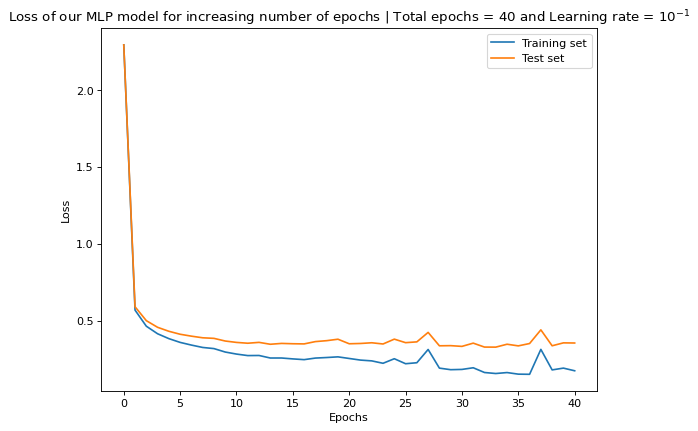

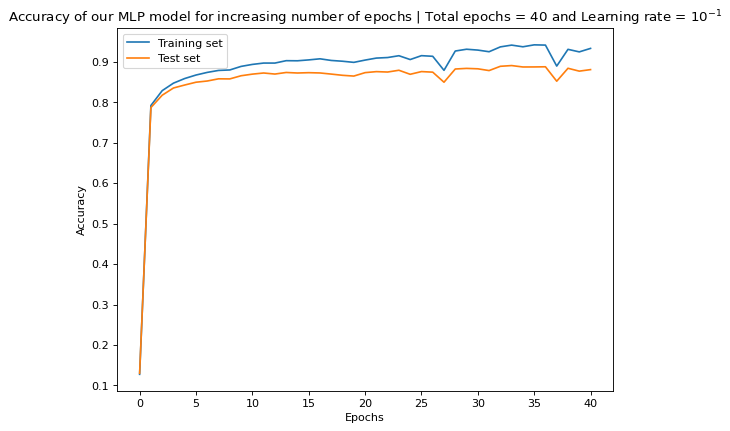

In [454]:
# Loss
plt.figure(figsize=(8, 6), dpi=80)
title = 'Loss of our MLP model for increasing number of epochs | Total epochs = 40 and Learning rate = $10^{-1}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(EPOCHS, trainLoss112ii, label = 'Training set')
plt.plot(EPOCHS, testLoss112ii, label = 'Test set')
plt.legend(loc = 'best')

# Accuracy
plt.figure(figsize=(8, 6), dpi=80)
title = 'Accuracy of our MLP model for increasing number of epochs | \
Total epochs = 40 and Learning rate = $10^{-1}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(EPOCHS, trainAcc112ii, label = 'Training set')
plt.plot(EPOCHS, testAcc112ii, label = 'Test set')
plt.legend(loc = 'best')

We here still observe that both the loss decreases and the accuracy increases as the number of epochs grows, for both the training and the testing set. However, we also observe that for a large number of epochs the metrics start wiggling. Moreover, the testing metrics stay less close to the training ones in this setting, despite still not displaying any strong overfitting for those numbers of epochs.

The model has here been trained with a rather big learning rate ($10^{-1}$), which results in fast but unstable convergence to optimum parameters. For the same number of epochs, the accuracy reached is higher and the loss lower. High learning rates can cause the optimization process to wether converge too fast to a suboptimal solution or to overshoot the exact location of the searched minimum. In this case, for a high number of epochs, as the parameters get closer to the optimum, the high learning rate cause the optimization process to occasionally slighlty move away from the minimum, worsening the metric for a given additional epoch.  

Overall, despite the unstability, with the chosen learning rate the loss reaches here a minimum of roughly 0.2, while the accuracy gets higher than 90%.

### 1.1.3

We perform a new training of our MLP model, on batches of 256 data points, using a learning rate of $10^{-3}$, this time going over 80 epochs. We again assess the loss function and the accuracy of said model, on both training and validation data, for each number of epochs computed. We further compare the metrics obtained with our previous results. 

In [435]:
###################################################################################################################

In [436]:
###################################################################################################################

In [445]:
###################################################################################################################
### DO NOT RUN AGAIN ###
t1 = time.time()
MLP113, trainLoss113, trainAcc113, testLoss113, testAcc113 = trainMLP(x_train, y_train, \
                                                                      x_test, y_test, epochs = 80, \
             learningRate = 1e-3, alpha = 1e-2)
t2 = time.time()
print('Wall time = ', t2 - t1)
### DO NOT RUN AGAIN ###
###################################################################################################################

Pre-training computations completed | Train Loss = 2.306007463638127 | Train Accuracy = 0.04618333333333333 | Test Loss = 2.3058068334751116 | Test Accuracy = 0.0449
Starting the training
Epoch N = 1 completed | Train Loss = 2.2619852599426205 | Train Accuracy = 0.2298 | Test Loss = 2.261980893824141 | Test Accuracy = 0.2336
Epoch N = 2 completed | Train Loss = 2.217625262689158 | Train Accuracy = 0.3531166666666667 | Test Loss = 2.2177809193266156 | Test Accuracy = 0.3518
Epoch N = 3 completed | Train Loss = 2.1620893661624447 | Train Accuracy = 0.4117 | Test Loss = 2.1623064656447832 | Test Accuracy = 0.4083
Epoch N = 4 completed | Train Loss = 2.0846933155177445 | Train Accuracy = 0.4838 | Test Loss = 2.085003650188507 | Test Accuracy = 0.4767
Epoch N = 5 completed | Train Loss = 1.9745178626188962 | Train Accuracy = 0.5434333333333333 | Test Loss = 1.9751860098729117 | Test Accuracy = 0.5361
Epoch N = 6 completed | Train Loss = 1.8255279501689294 | Train Accuracy = 0.56995 | Test L

Epoch N = 55 completed | Train Loss = 0.5084489370650195 | Train Accuracy = 0.8248333333333333 | Test Loss = 0.5370373124271098 | Test Accuracy = 0.8116
Epoch N = 56 completed | Train Loss = 0.5053315963103903 | Train Accuracy = 0.8256666666666667 | Test Loss = 0.5341733209202788 | Test Accuracy = 0.8121
Epoch N = 57 completed | Train Loss = 0.5023162925806417 | Train Accuracy = 0.8265166666666667 | Test Loss = 0.5314062211143579 | Test Accuracy = 0.8129
Epoch N = 58 completed | Train Loss = 0.49939146206708646 | Train Accuracy = 0.8272666666666667 | Test Loss = 0.5287139955551609 | Test Accuracy = 0.814
Epoch N = 59 completed | Train Loss = 0.49656583787240566 | Train Accuracy = 0.82835 | Test Loss = 0.5261126423213934 | Test Accuracy = 0.8149
Epoch N = 60 completed | Train Loss = 0.49383049205973634 | Train Accuracy = 0.82965 | Test Loss = 0.5235986101249804 | Test Accuracy = 0.8157
Epoch N = 61 completed | Train Loss = 0.4911809678775443 | Train Accuracy = 0.8305 | Test Loss = 0.521

In [437]:
###################################################################################################################

In [438]:
###################################################################################################################

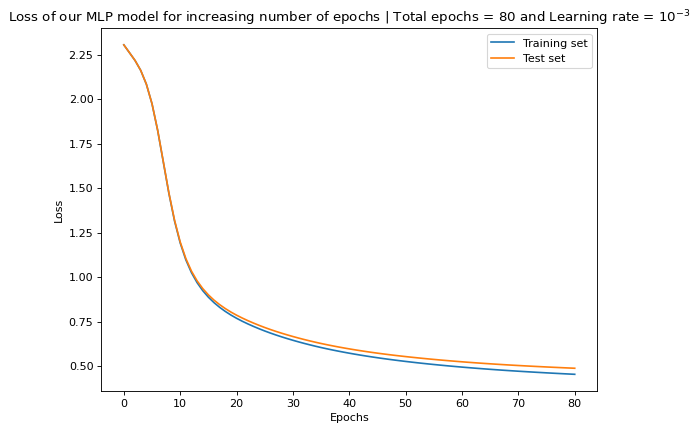

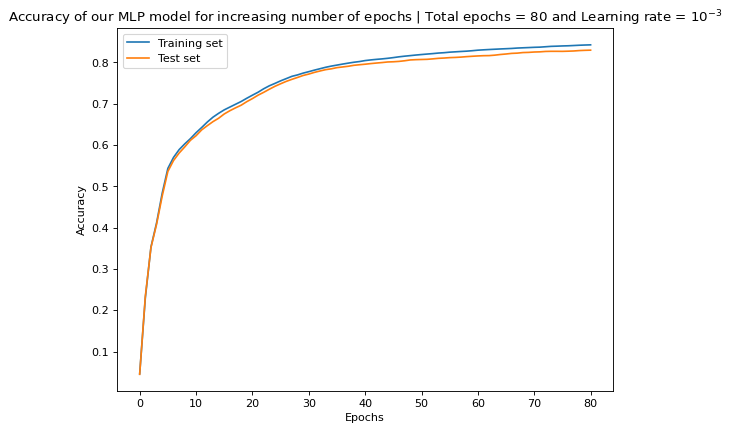

In [456]:
EPOCHS = np.array([N for N in range(81)])

# Loss
plt.figure(figsize=(8, 6), dpi=80)
title = 'Loss of our MLP model for increasing number of epochs | Total epochs = 80 and Learning rate = $10^{-3}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(EPOCHS, trainLoss113, label = 'Training set')
plt.plot(EPOCHS, testLoss113, label = 'Test set')
plt.legend(loc = 'best')

# Accuracy
plt.figure(figsize=(8, 6), dpi=80)
title = 'Accuracy of our MLP model for increasing number of epochs | \
Total epochs = 80 and Learning rate = $10^{-3}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(EPOCHS, trainAcc113, label = 'Training set')
plt.plot(EPOCHS, testAcc113, label = 'Test set')
plt.legend(loc = 'best')

Again, we observe that both the loss decreases and the accuracy increases continuously as the number of epochs grows, for both the training and the testing set. The testing metrics stay close to the training ones, not displaying any overfitting for this higher number of total epochs.

The learning rate has been chosen the same as in 1.1.1, whereas the training has been made over 80 epochs here. The metrics globally follow the same trend then what has been seen in 1.1.1, gowing further as the number of epochs is larger. Thus, the metrics are here better then what was given in 1.1.1 : approximately 84% in accuracy and less than 0.5 in loss. The gradient descent continues steadily toward an optimum set of parameters, however having a convergence rate that is rather slow. 

We have seen that using a learning rate of $10^{-1}$ leads to having an accuracy close to 90%, but with an unstable optimization path. Hence, one may perhaps find a more optimal learning rate (fast, optimal and stable convergence) inbetween $10^{-1}$ and $10^{-3}$. 

<a name="q12"></a>
## 1.2 Convolutional neural network (CNN) [^](#outline)

We now implement a CNN using the $\texttt{tensorflow}$ library. The network will be composed of one 784-neurons input layer (28$\times$ 28 pixels for the images), four convolutional hidden layers, one fully-connected 64-neurons hidden layer, and one 10-neurons output layer (one neuron for each class). The convolutional layers apply 3 ✕ 3 filters, the first two using 8 feature maps and the last two using 16 feature maps. The last convolutional layer is followed by a 2 ✕ 2 max-pool layer. Again, the activation function between all layers will be the $\texttt{LeakyReLU}$ function, except for the output layer which will use a softmax function as activation. The loss function will be cross-entropy, and the optimisation of the network parameters will be made using stochastic gradient descent.

### 1.2.1

We perform the training of our CNN model, using $\texttt{tensorflow}$ pre-implemented methods, on batches of 256 data points, with a learning rate of $10^{-3}$, on 40 epochs. We assess the loss function and the accuracy of said model, on both training and validation data, for each number of epochs computed. 

In [580]:
# Defining our model through tensorflow specific method

input_shape = (28, 28, 1) # 28 x 28 input images

leakyRELUfunc = tf.keras.layers.LeakyReLU(alpha=0.01)

model = Sequential([ # Tensorflow model
        Conv2D(filters = 8, kernel_size = (3,3), activation = leakyRELUfunc, input_shape = input_shape),# Conv layer
        Conv2D(filters = 8, kernel_size = (3,3), activation = leakyRELUfunc), # Convolutional layer
        Conv2D(filters = 16, kernel_size = (3,3), activation = leakyRELUfunc), # Convolutional layer
        Conv2D(filters = 16, kernel_size = (3,3), activation = leakyRELUfunc), # Convolutional layer
        MaxPooling2D(pool_size = (2, 2)), # Maximum pooling layer
        Flatten(), # Flattening
        Dense(64, activation = leakyRELUfunc), # Fully-connected layer
        Dense(10, activation = 'softmax') # Output layer
    ])

learning_rate = 1e-3
# Using stochastic gradient descent
opt = tf.keras.optimizers.SGD(learning_rate = learning_rate) 
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy']) # Using CE
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_200 (Conv2D)         (None, 26, 26, 8)         80        
                                                                 
 conv2d_201 (Conv2D)         (None, 24, 24, 8)         584       
                                                                 
 conv2d_202 (Conv2D)         (None, 22, 22, 16)        1168      
                                                                 
 conv2d_203 (Conv2D)         (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 10, 10, 16)       0         
 g2D)                                                            
                                                                 
 flatten_50 (Flatten)        (None, 1600)              0         
                                                     

In [581]:
# Training our model
batch_size = 256
numberEpochs = 40

t1 = time.time()

with tf.device('/device:GPU:0'):
  metrics = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = numberEpochs, verbose = 1,
                      validation_data = (x_test, y_test), shuffle = True) # verbose = 1 gives a progress bar

t2 = time.time()
print('Wall time = ', t2 - t1)

Epoch 1/40
235/235 [==============================] - 23s 98ms/step - loss: 2.2661 - accuracy: 0.1523 - val_loss: 2.2373 - val_accuracy: 0.2025
Epoch 2/40
235/235 [==============================] - 27s 116ms/step - loss: 2.1847 - accuracy: 0.2589 - val_loss: 2.1006 - val_accuracy: 0.3467
Epoch 3/40
235/235 [==============================] - 25s 105ms/step - loss: 1.8239 - accuracy: 0.4406 - val_loss: 1.3815 - val_accuracy: 0.5574
Epoch 4/40
235/235 [==============================] - 26s 111ms/step - loss: 1.0932 - accuracy: 0.6196 - val_loss: 0.9547 - val_accuracy: 0.6533
Epoch 5/40
235/235 [==============================] - 24s 101ms/step - loss: 0.8801 - accuracy: 0.6779 - val_loss: 0.8448 - val_accuracy: 0.6885
Epoch 6/40
235/235 [==============================] - 32s 136ms/step - loss: 0.8014 - accuracy: 0.7078 - val_loss: 0.8450 - val_accuracy: 0.7001
Epoch 7/40
235/235 [==============================] - 25s 106ms/step - loss: 0.7602 - accuracy: 0.7214 - val_loss: 0.7535 - val_acc

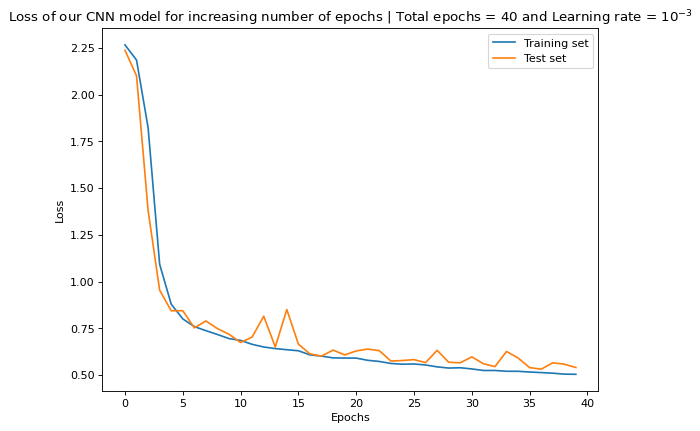

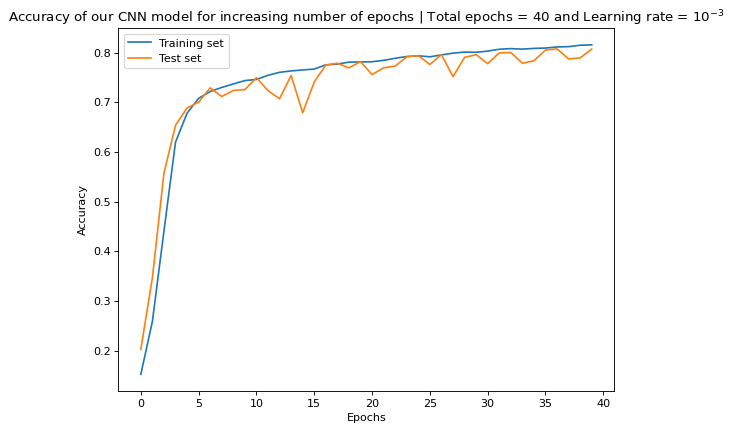

In [582]:
EPOCHS = np.array([N for N in range(40)])

# Loss
plt.figure(figsize=(8, 6), dpi=80)
title = 'Loss of our CNN model for increasing number of epochs | Total epochs = 40 and Learning rate = $10^{-3}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(EPOCHS, metrics.history['loss'], label = 'Training set')
plt.plot(EPOCHS, metrics.history['val_loss'], label = 'Test set')
plt.legend(loc = 'best')

# Accuracy
plt.figure(figsize=(8, 6), dpi=80)
title = 'Accuracy of our CNN model for increasing number of epochs | \
Total epochs = 40 and Learning rate = $10^{-3}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(EPOCHS, metrics.history['accuracy'], label = 'Training set')
plt.plot(EPOCHS, metrics.history['val_accuracy'], label = 'Test set')
plt.legend(loc = 'best')

Using a CNN model, we observe the same pattern as in 1.1.1 : on the one hand the loss decreases as the number of epochs grows, for both the training and the testing set, this decrease slowing down for higher epochs, converging to a minimal value, and on the other hand the accuracy increases as the number of epochs grows, for both the training and the testing set, converging to a maximal value. 

With this model, while the train set metrics evolve quite monotonically, the test set metrics (loss and accuracy) follow the training set metrics unsteadily, oscillating and having an accuracy globally slighlty lower and a loss globally slighlty greater. Overall, the test set metrics values stay close to the ones of the training set, not displaying any overfitting for less than 40 epochs here. 

In absolute value, the model performances are quite similar to what was given by the 1.1.1 MLP : in 40 epochs, it reaches roughly 80% of accuracy, for a loss close to 0.5. We might further increase the complexity of the model to obtain better performances.  

### 1.2.2

We now add Dropout in the fully connected layer. We scan a range of dropout probability hyperparameters, dividing the training set into 80% training data points and 20% validation data points, to find an optimal value, using accuracy as the measure of performance.

In [486]:
# Creating a validation set
# Using kNN Coding Task code
p = np.random.permutation(len(y_train))
x_trainShuf = x_train[p]
y_trainShuf = y_train[p]
# 80%/20% split
split_rate = 0.8
x_trainSplit, x_val = np.split(x_trainShuf, [int(split_rate*(x_trainShuf.shape[0]))])
y_trainSplit, y_val = np.split(y_trainShuf, [int(split_rate*(y_trainShuf.shape[0]))])

In [514]:
###################################################################################################################

In [515]:
###################################################################################################################

In [510]:
###################################################################################################################
### DO NOT RUN AGAIN ###
# Scanning probability hyperparameter

# Initializing metrics container
scanMetrics = {}

# Model fixed parameters
input_shape = (28, 28, 1) # 28 x 28 input images
leakyRELUfunc = tf.keras.layers.LeakyReLU(alpha=0.01) # LeakyReLU function
learning_rate = 1e-3 # Learning rate
batch_size = 256 # Batch size
numberEpochs = 40 # Epochs
opt = tf.keras.optimizers.SGD(learning_rate = learning_rate) # Using stochastic gradient descent

probability = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]) # Hyperparameter scan

step = 0 # Keeping track of computation progress

for p in probability : # Scanning
    
    step += 1
    print('Completing training : ' + str(step) + '/9')

    model = Sequential([ # Tensorflow model
            Conv2D(filters = 8, kernel_size = (3,3), activation = leakyRELUfunc, input_shape = input_shape),
            Conv2D(filters = 8, kernel_size = (3,3), activation = leakyRELUfunc), # Convolutional layer
            Conv2D(filters = 16, kernel_size = (3,3), activation = leakyRELUfunc), # Convolutional layer
            Conv2D(filters = 16, kernel_size = (3,3), activation = leakyRELUfunc), # Convolutional layer
            MaxPooling2D(pool_size = (2, 2)), # Maximum pooling layer
            Flatten(), # Flattening
            Dense(64, activation = leakyRELUfunc), # Fully-connected layer
            Dropout(p), ### Dropout with current p ###
            Dense(10, activation = 'softmax') # Output layer
        ])

    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy']) # Using CE
    
    with tf.device('/device:GPU:0'):
      metrics = model.fit(x = x_trainSplit, y = y_trainSplit, batch_size = batch_size, 
                          epochs = numberEpochs, verbose = 0,
                      validation_data = (x_val, y_val), shuffle = True) # Training
    
    # Storing metrics
    scanMetrics[str(p)] = metrics.history
### DO NOT RUN AGAIN ###
###################################################################################################################

Completing training : 1/9
Completing training : 2/9
Completing training : 3/9
Completing training : 4/9
Completing training : 5/9
Completing training : 6/9
Completing training : 7/9
Completing training : 8/9
Completing training : 9/9


In [512]:
###################################################################################################################

In [513]:
###################################################################################################################

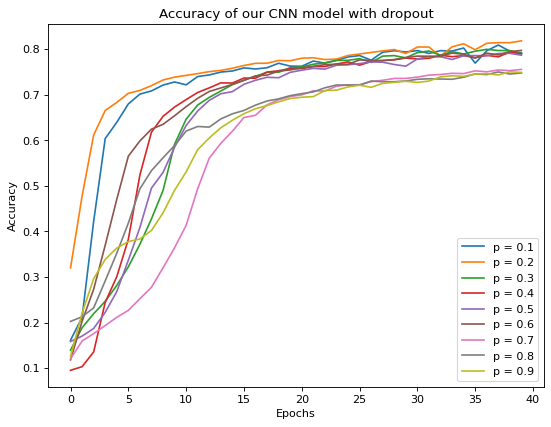

In [529]:
# Visualize some accuracies on validation data
plt.figure(figsize=(8, 6), dpi=80)
title = 'Accuracy of our CNN model with dropout'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
for p in probability :
    plt.plot(EPOCHS, scanMetrics[str(p)]['val_accuracy'], label = 'p = ' + str(p))
plt.legend(loc = 'best')

In [532]:
# All accuracies are globally increasing
# We seek p such that the best accuracy over the 40 epochs is maximum

# Computing the max accuracy for all p
maxScanMetrics = np.zeros(9)
for ind, p in enumerate(probability) :
    maxScanMetrics[ind] = np.max(scanMetrics[str(p)]['val_accuracy']) # On validation data
    
bestProbaindex = np.argmax(maxScanMetrics)
bestProbability = probability[bestProbaindex]

print('The optimal dropout probability is : p = ' + str(bestProbability))

The optimal dropout probability is : p = 0.2


We now retrain the model on the full training data, having dropout with optimal probability 0.2.

In [583]:
# Defining our model through tensorflow specific method | Best probability

input_shape = (28, 28, 1) # 28 x 28 input images

leakyRELUfunc = tf.keras.layers.LeakyReLU(alpha=0.01)

model2 = Sequential([ # Tensorflow model
        Conv2D(filters = 8, kernel_size = (3,3), activation = leakyRELUfunc, input_shape = input_shape),# Conv layer
        Conv2D(filters = 8, kernel_size = (3,3), activation = leakyRELUfunc), # Convolutional layer
        Conv2D(filters = 16, kernel_size = (3,3), activation = leakyRELUfunc), # Convolutional layer
        Conv2D(filters = 16, kernel_size = (3,3), activation = leakyRELUfunc), # Convolutional layer
        MaxPooling2D(pool_size = (2, 2)), # Maximum pooling layer
        Flatten(), # Flattening
        Dense(64, activation = leakyRELUfunc), # Fully-connected layer
        Dropout(bestProbability), ### Dropout with best p ###
        Dense(10, activation = 'softmax') # Output layer
    ])

learning_rate = 1e-3
# Using stochastic gradient descent
opt = tf.keras.optimizers.SGD(learning_rate = learning_rate) 
model2.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy']) # Using CE
model2.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         (None, 26, 26, 8)         80        
                                                                 
 conv2d_205 (Conv2D)         (None, 24, 24, 8)         584       
                                                                 
 conv2d_206 (Conv2D)         (None, 22, 22, 16)        1168      
                                                                 
 conv2d_207 (Conv2D)         (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 10, 10, 16)       0         
 g2D)                                                            
                                                                 
 flatten_51 (Flatten)        (None, 1600)              0         
                                                     

In [584]:
# Training our model | Best probability
batch_size = 256
numberEpochs = 40

t1 = time.time()

with tf.device('/device:GPU:0'):
  metrics = model2.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = numberEpochs, verbose = 1,
                      validation_data = (x_test, y_test), shuffle = True) # verbose = 1 gives a progress bar

t2 = time.time()
print('Wall time = ', t2 - t1)

Epoch 1/40
235/235 [==============================] - 29s 122ms/step - loss: 2.2959 - accuracy: 0.1045 - val_loss: 2.2912 - val_accuracy: 0.1114
Epoch 2/40
235/235 [==============================] - 27s 113ms/step - loss: 2.2867 - accuracy: 0.1272 - val_loss: 2.2802 - val_accuracy: 0.1424
Epoch 3/40
235/235 [==============================] - 30s 127ms/step - loss: 2.2721 - accuracy: 0.1496 - val_loss: 2.2593 - val_accuracy: 0.1686
Epoch 4/40
235/235 [==============================] - 25s 106ms/step - loss: 2.2385 - accuracy: 0.1721 - val_loss: 2.2028 - val_accuracy: 0.1808
Epoch 5/40
235/235 [==============================] - 25s 106ms/step - loss: 2.1272 - accuracy: 0.2165 - val_loss: 1.9775 - val_accuracy: 0.2878
Epoch 6/40
235/235 [==============================] - 24s 104ms/step - loss: 1.7098 - accuracy: 0.4173 - val_loss: 1.3032 - val_accuracy: 0.5711
Epoch 7/40
235/235 [==============================] - 25s 106ms/step - loss: 1.2711 - accuracy: 0.5364 - val_loss: 1.0377 - val_ac

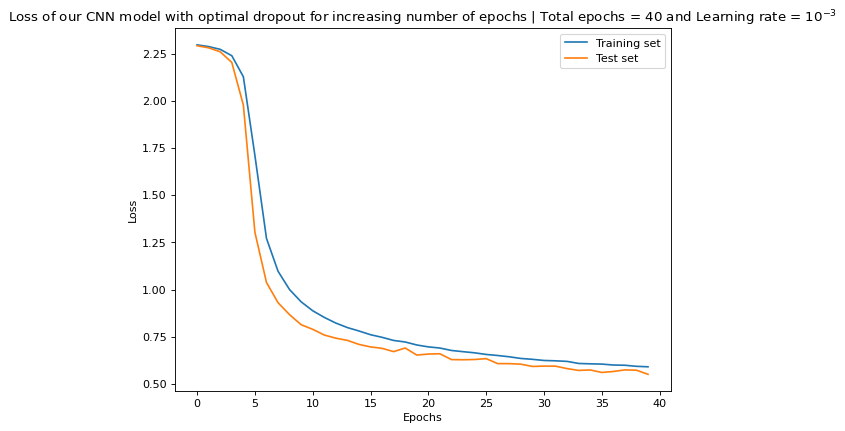

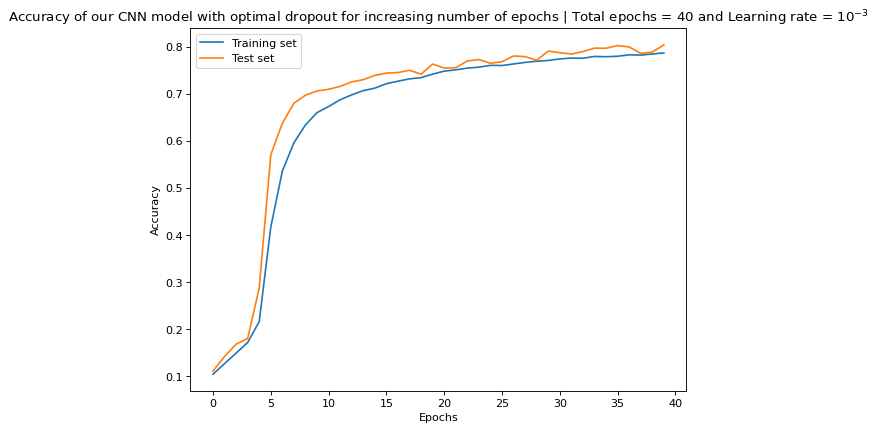

In [585]:
# Loss
plt.figure(figsize=(8, 6), dpi=80)
title = 'Loss of our CNN model with optimal dropout \
for increasing number of epochs | Total epochs = 40 and Learning rate = $10^{-3}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(EPOCHS, metrics.history['loss'], label = 'Training set')
plt.plot(EPOCHS, metrics.history['val_loss'], label = 'Test set')
plt.legend(loc = 'best')

# Accuracy
plt.figure(figsize=(8, 6), dpi=80)
title = 'Accuracy of our CNN model with optimal dropout \
for increasing number of epochs | Total epochs = 40 and Learning rate = $10^{-3}$'
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(EPOCHS, metrics.history['accuracy'], label = 'Training set')
plt.plot(EPOCHS, metrics.history['val_accuracy'], label = 'Test set')
plt.legend(loc = 'best')

As previously, the loss decreases as the number of epochs grows, for both the training and the testing set, and the accuracy increases as the number of epochs grows, also for both sets.

The model's performance is slighlty worse then what was given by the 1.2.1 CNN (without dropout). The final loss on the train set is now 0.5911 (against 0.5051 in 1.2.1), and the final accuracy on the train set is now 78.77% (against 81.54% in 1.2.1). The final loss on the test set is now 0.5514 (against 0.5416 in 1.2.1), and the final accuracy on the train set is now 80.50% (against 80.69% in 1.2.1). 

As dropout usually improves accuracy, we may perhaps have that in this setting, as the model doesn't overfit for 40 epochs of training, the implementation of said regularisation method is an unfavorable overkill of the model's complexity.

We investigate further by plotting the activations of the fully-connected layer when evaluated on the test set.

<BarContainer object of 30 artists>

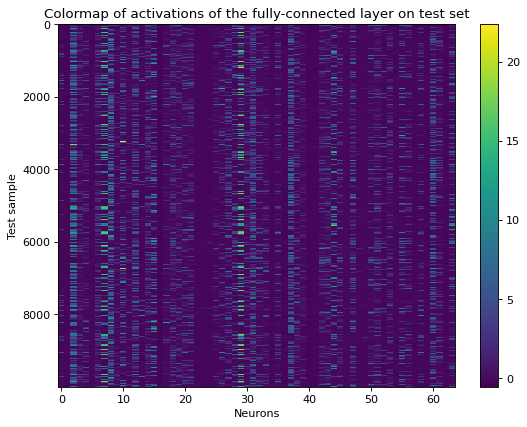

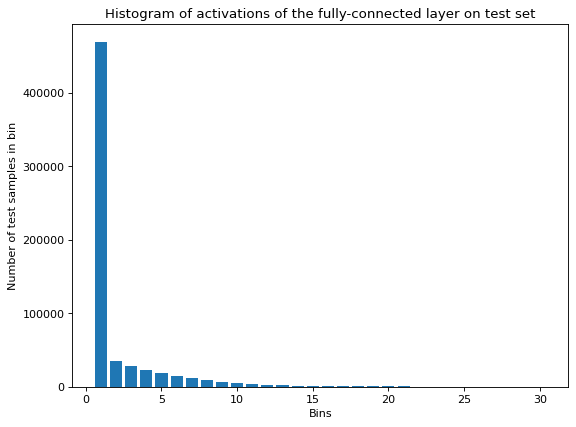

In [638]:
# Retreiving the activations of the FC layer over the test set
  

# With dropout
layerOutput2 = model2.layers[7].output
activationModel2 = models.Model(inputs = model2.input, outputs = layerOutput2) 
activations2 = activationModel2.predict(x_test) 
fig2 = plt.figure(figsize=(8, 6), dpi=80)
fig2 = plt.imshow(activations2, interpolation='nearest', aspect = 'auto')
plt.title('Colormap of activations of the fully-connected layer on test set')
plt.xlabel('Neurons')
plt.ylabel('Test sample')
plt.colorbar(fig2)

hist = np.histogram(activations2, bins = 30)[0]
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Histogram of activations of the fully-connected layer on test set')
plt.xlabel('Bins')
plt.ylabel('Number of test samples in bin')
plt.bar(np.array([k for k in range(1,31)]),hist)

The dropout regularisation process prevents pairs of neurons from co-adapting and further reduces overfitting. The process randomly zero-outs neurons during the training phase, ultimately lowering the parameters magnitude and inducing sparsity in the model. By reducing overfitting, this method is intended to give better accuracies on unseen data, such as the data points of the testing set.  

The colormap displays a high number of lower-activated neurons, having only a specific subset of neurons being truly active. Moreover, the given histogram well shows that the majority of activation values are comparatively small. We here observe that after the implementation of dropout, lesser neurons hold high-valued activations, leaving fewer well-activated ones that are triggered only when relevant patterns appear on the input image.   

### 1.2.3

We now compare the results obtained with our previous MLP model and the ones given by the current CNN with dropout model.

The two different models do not hold the same complexity and the same amount of parameters. The MLP model is made of one 784-neurons entry layer, five 400-neurons hidden layers, and one 10-neurons output layer. Thus, the MLP is made of 959 610 parameters (see count below). As seen using the $\texttt{model2.summary()}$ method, the CNN model is itself composed of 107 266 parameters. Hence, the MLP holds in somehow more complexity than the CNN model, with almost 10 times more parameters in it. However, as we have seen by investigating the performances of both model, the CNN is able to acheive 80.50% accuracy on testing data, where MLP acheives only 79.35%.

Having a slightly better accuracy with substantially less parameters highlights that the CNN's architecture is more relevant to perform image classification, as the convolutional layers feature extraction process proves really well suited for this task. The CNN convolutional layers filters take into account the spatial structure of the input data, which here holds relevant information for the classification process. As the MLP takes the flatten version of the images as input, it further loses this useful information, and ultimately performs less well in said task.  

In [623]:
# Counting MLP parameters
MLPSize = 0
for key in MLP.keys() :
    MLPSize += MLP[key]['W'].shape[0] * MLP[key]['W'].shape[1]
    MLPSize += MLP[key]['b'].shape[0]
print('Number of parameters in MLP = ', MLPSize)

Number of parameters in MLP =  959610


### 1.2.4

We now choose a sample image from the testing set, and visualise one feature map extracted on said sample for each convolutional layer.

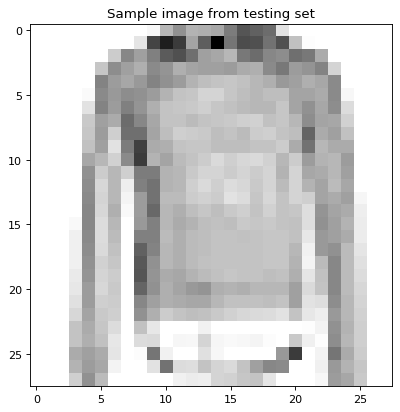

In [699]:
# Taking a sample image from the testing set and displaying it
imgSample = x_test[16]

plt.figure(figsize=(8, 6), dpi=80)
plt.title('Sample image from testing set')
plt.imshow(imgSample, cmap = 'Greys')

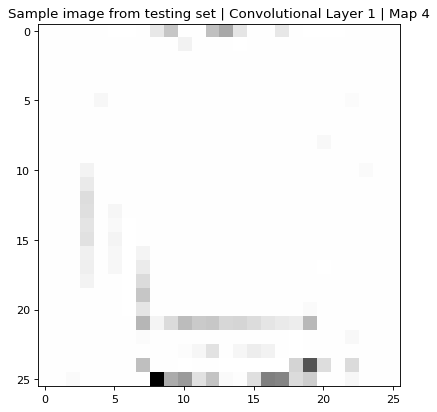

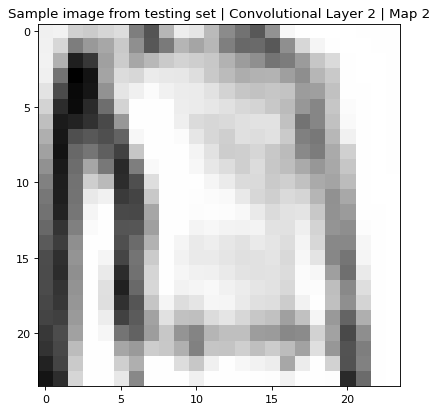

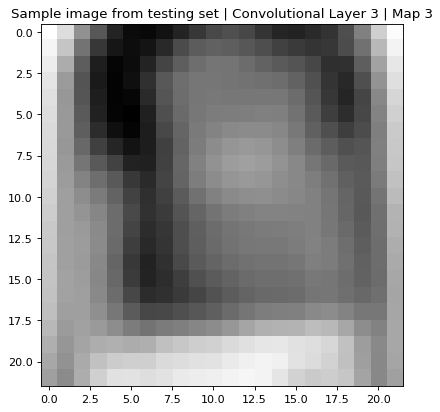

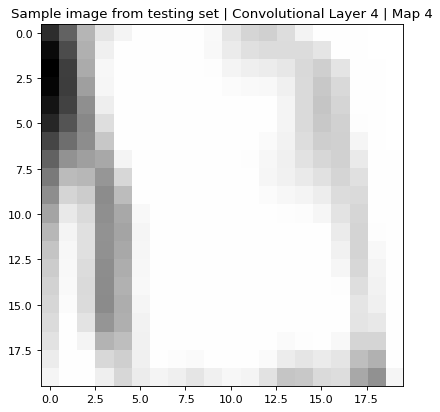

In [712]:
# Preparing the extraction process
layerOutput3 = [layer.output for layer in model2.layers[:4]] 
activationModel3 = models.Model(inputs = model2.input, outputs = layerOutput3) 
activations3 = activationModel3.predict(x_test) 

# Extracting

plt.figure(figsize=(8, 6), dpi=80)
plt.title('Sample image from testing set | Convolutional Layer 1 | Map 4')
plt.imshow(activations3[0][16][:,:,5], cmap = 'Greys')

plt.figure(figsize=(8, 6), dpi=80)
plt.title('Sample image from testing set | Convolutional Layer 2 | Map 2')
plt.imshow(activations3[1][16][:,:,2], cmap = 'Greys') 

plt.figure(figsize=(8, 6), dpi=80)
plt.title('Sample image from testing set | Convolutional Layer 3 | Map 3')
plt.imshow(activations3[2][16][:,:,3], cmap = 'Greys') 

plt.figure(figsize=(8, 6), dpi=80)
plt.title('Sample image from testing set | Convolutional Layer 4 | Map 4')
plt.imshow(activations3[3][16][:,:,5], cmap = 'Greys') 

The image chosen is a sweater or a shirt. We observe that the first convolutional layer selected filter mainly detects top, side and bottom edges on the image. The second layer seems to be detecting sleeves and sides of the clothing. The third layer chosen filter detects the overall shape and provides a mask of the shirt/hoodie. The last layer globally outlines the sweater.

<a name="task-2"></a>

# Task 2: Unsupervised learning [^](#outline)

We here perform dimensionality reduction and clustering on the previously used Fashion-MNIST image dataset. We also study the social network made of the observed interactions between 62 bottlenose dolphins. We are provided with a set of features characterizing the dolphins, an adjacency matrix describing their interactions, as well as a list containing their names. We perform clustering and a graph-based analysis on this new dataset.

<a name="q21"></a>

## 2.1 Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data [^](#outline)

We consider the first 1000 images of the Fashion-MNIST dataset. We use the corresponding ones of our previously built training set. 

In [739]:
# Adapting dataset to current setting
x_adapt = np.zeros((1000,784))
for k in range(1000) :
    x_adapt[k,:] = x_train[k].flatten()
print('Adapted data shape : ', x_adapt.shape)

Adapted data shape :  (1000, 784)


### 2.1.1

We normalize and center the data, and perform a principal component analysis to reduce dimensionality. We use the solutions provided with the Coding Task 11.

In [726]:
### Not modifying this solution function of Coding Task 11 ###

def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [743]:
# Standardizing data
x_bar = standardise(x_adapt)

In [745]:
### Not modifying this solution function of Coding Task 11 ###

def pca_function(X,k):

    # create covariance matrix S
    C = 1.0/(len(X)-1) * np.dot(X.T, X) 


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

In [776]:
X_pca, eigenvectors, eigenvalues = pca_function(X = x_bar,k = 25)
print('X_PCA for m = 25 : ')
print(X_pca)

X_PCA for m = 25 : 
[[ 1.46121129e+00  2.04244189e+01  2.80783889e+00 ...  9.00525462e-01
   2.40991919e-01  1.68976693e+00]
 [-1.77466462e+01 -4.43726285e+00  4.70397008e+00 ... -3.36196535e+00
   9.36127789e-01  4.76106467e+00]
 [ 8.58548541e+00 -1.27262507e+01  2.90980387e+00 ... -2.93627705e-01
   1.01655259e+00  8.38183047e-03]
 ...
 [ 1.19714527e+01 -1.12134249e+01  6.13705570e+00 ... -1.21803965e+00
  -3.28197769e-01 -5.16328139e-01]
 [ 5.44715192e+00  1.74047312e+01  8.30851950e+00 ...  2.10387031e+00
  -1.66796229e+00  4.72634980e-01]
 [ 1.52337351e+00  1.77582983e+01 -3.93460432e+00 ...  1.01419142e+00
  -7.78776085e-01 -2.20435909e+00]]


### 2.1.2

We compute the top 25 principal components and further plot the corresponding eigenvalues and fraction of variance explained. 

In [752]:
### Using this code from Coding Task 11 ###

C = 1.0/(len(x_bar)-1) * np.dot(x_bar.T, x_bar) # Covariance matrix
all_eigenvalues, _ = np.linalg.eig(C) # Eigenvalues
total_variance = abs(all_eigenvalues.sum()) # V total variance

Eigenvalues top 25 PCA : 
[175.66089464 111.62355222  43.4966843   41.18450153  31.48763816
  25.32376493  21.55962472  19.17773943  13.93177743  11.40453119
   9.75938021   8.92160146   8.48284988   7.38576291   6.86866163
   6.29977712   5.34035713   5.10960449   4.99623556   4.84225066
   4.49460793   4.38523252   4.14193145   3.90760562   3.69301298]



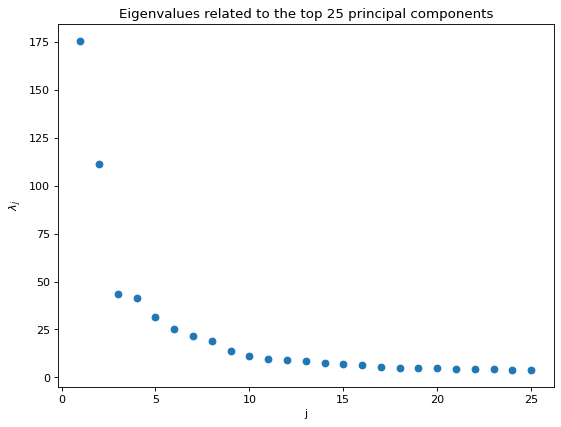

In [779]:
# Investigation

_, eigenvectors, eigenvalues = pca_function(X = x_bar,k = 25)
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Eigenvalues related to the top 25 principal components')
plt.xlabel('j')
plt.ylabel('$\lambda_j$')
plt.scatter(x = [i+1 for i in range(25)],y = eigenvalues)

print('Eigenvalues top 25 PCA : ')
print(eigenvalues)

print('')

In [781]:
# Fraction of variance explained
fracVarExp = eigenvalues / total_variance
print('Fraction of variance explained for each m : ')
print(fracVarExp)
print('')

VE = 0 # Sum of fraction of variance explained
for i in range(25) :
    VE += eigenvalues[i] / total_variance
    print('Sum of fractions of variance explained until m = ' + str(i+1) + ' : ' + str(VE))

Fraction of variance explained for each m : 
[0.224693   0.14278096 0.05563788 0.0526803  0.04027676 0.03239237
 0.02757755 0.02453081 0.01782055 0.01458787 0.01248351 0.01141188
 0.01085066 0.00944735 0.00878591 0.00805823 0.00683101 0.00653584
 0.00639083 0.00619386 0.00574918 0.00560928 0.00529807 0.00499833
 0.00472384]

Sum of fractions of variance explained until m = 1 : 0.2246930009599011
Sum of fractions of variance explained until m = 2 : 0.3674739595562051
Sum of fractions of variance explained until m = 3 : 0.42311184382648176
Sum of fractions of variance explained until m = 4 : 0.4757921473185409
Sum of fractions of variance explained until m = 5 : 0.5160689085480877
Sum of fractions of variance explained until m = 6 : 0.5484612787917944
Sum of fractions of variance explained until m = 7 : 0.5760388269258343
Sum of fractions of variance explained until m = 8 : 0.6005696357468633
Sum of fractions of variance explained until m = 9 : 0.6183901807624339
Sum of fractions of vari

The eigenvalue plot shows that we here have an ideal case scenario. Two eigenvalues are fairly large comparatively to the remaining ones. This results in a 'drastic drop' in the eigenvalues magnitude, $\textbf{showing that $m$=2 is a natural choice for reducing the dimensionnality}$ while keeping most of the information contained in the dataset. 

Moreover, by computing the fraction of variance explained we see that the top 2 components accounts for almost 37% of the total variance alone. By computing the sum of ratios, the first 25 components reaches almost 75% of the total variance, displaying the strong redundancy contained in the information of the 784 predictors.

### 2.1.3

We focus on the top 2 principal components, and plot the data in the corresponding 2-dimensionnal space spanned by said components. Each data point will be colored according to its ground truth class (used in 1.). 

In [787]:
# Mapping classes to integers
y_adapt = np.zeros(1000) # Containing an integer representing the data point's class
for n in range(1000) :
    y_adapt[n] = np.argmax(y_train[n]) # y_train[n] is filled with zeros and one 1
print('New representation of classes sample : ')
print(y_adapt[10:15])

New representation of classes sample : 
[0. 9. 5. 5. 7.]


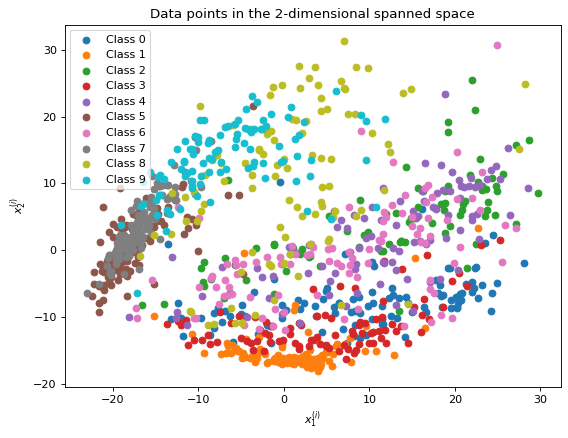

In [798]:
# X_pca contains the coordinates of the 1000 
# data points in the 2-dimensional space of the principal components
X_pca, eigenvectors, eigenvalues = pca_function(X = x_bar,k = 2)

# Plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
classes = y_adapt
for c in np.unique(classes):
    i = np.where(classes == c)
    ax.scatter(x = X_pca[i,0], y = X_pca[i,1], label = 'Class ' + str(int(c)))
ax.legend()
plt.title('Data points in the 2-dimensional spanned space')
plt.xlabel('$x^{(i)}_1$')
plt.ylabel('$x^{(i)}_2$')
plt.show()

We observe that in this top 2 components 2-dimensionnal space, the different classes are well-clustered, globally stacked together in different regions of the plane (especially class 7 and 1). The two predictors are strongly relevant (although not perfect, some dispersion remains) to distinguish the different types on data points present here.  

### 2.1.4

We now apply the $k$-means algorithm to cluster the data points of the 2-dimensionnal subspace. We seek to find an optimal hyperparameter $k$. 

In [874]:
### Using Coding Task 10 solutions ###

def kMeans(X, k, max_iter = 100, prints = True) :
    """
    This function implements the k-means algorithm on data from X.

    Parameters
    ----------
    X : an Nxp-dimensional numpy array - our input data points
    k : an integer - the number of clusters 
    max_iter : an integer - the maximum number of iterations
    prints : a boolean - if set to True the functions prints the iterations

    Returns
    -------
    centroids : an pxk-dimensional numpy array - the clusters' centroids coordinates
    X_labels : an Nx(p+1)-dimensional numpy array - our input data points with corresponding cluster label
    """
    
    n_samples, n_features = X.shape

    # labels: assign every sample to a cluster at random
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:2] 
        
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        if prints :
            print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            if prints :
                print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            if prints :
                print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)   
                    
    return centroids, labels

In [30]:
def computeDistances(X) :
    """
    This function computes the distances between the data points in X.

    Parameters
    ----------
    X : an Nxp-dimensional numpy array - our input data points

    Returns
    -------
    D : an NxN-dimensional numpy array - the euclidean distances square between the points in X
    """
    
    N = X.shape[0]
    
    D = np.zeros((N,N))
    
    for i in range(N) :
        for j in range(N) :
            
            if i != j : # Zeros on diagonal D(x_i,x_i) = 0
                
                if D[j,i] != 0 : # If symmetric entry has already been computed 
                    
                    D[i,j] = D[j,i] # Symmetric matrix => D(x_i,x_j) = D(x_j,x_i)
                    
                else :
                    
                    D[i,j] = np.linalg.norm(X[i,:]-X[j,:])**2
                    
    return D

In [865]:
# Computing distances
D = computeDistances(X_pca)

In [889]:
# Computing k-means for k = 10
centroids, labels = kMeans(X = X_pca, k = 10, max_iter = 100)

Iteration: 0
88.100000% labels changed
Iteration: 1
24.200000% labels changed
Iteration: 2
12.000000% labels changed
Iteration: 3
5.600000% labels changed
Iteration: 4
3.100000% labels changed
Iteration: 5
2.500000% labels changed
Iteration: 6
3.100000% labels changed
Iteration: 7
3.300000% labels changed
Iteration: 8
3.500000% labels changed
Iteration: 9
3.100000% labels changed
Iteration: 10
2.600000% labels changed
Iteration: 11
1.800000% labels changed
Iteration: 12
1.500000% labels changed
Iteration: 13
1.700000% labels changed
Iteration: 14
1.600000% labels changed
Iteration: 15
0.900000% labels changed
Iteration: 16
0.700000% labels changed
Iteration: 17
0.900000% labels changed
Iteration: 18
1.000000% labels changed
Iteration: 19
0.700000% labels changed
Iteration: 20
0.500000% labels changed
Iteration: 21
0.400000% labels changed
Iteration: 22
0.200000% labels changed
Iteration: 23
0.100000% labels changed
Iteration: 24
Labels unchanged! Terminating k-means.


In [890]:
# Displaying some cluster classes
print('Some data points cluster number : ')
labels[10:15]

Some data points cluster number : 


array([2, 7, 9, 9, 9])

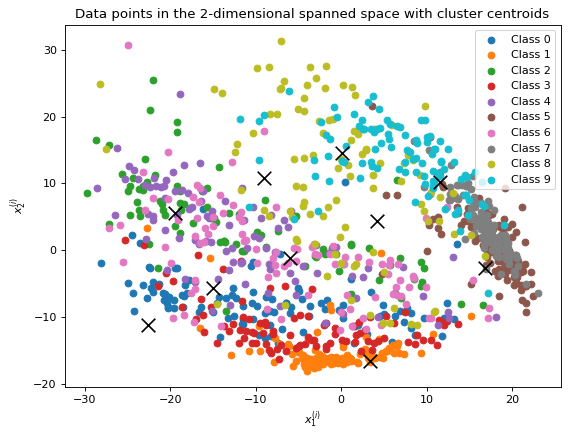

In [891]:
# Plotting data with centroids for k = 10

# X_pca contains the coordinates of the 1000 
# data points in the 2-dimensional space of the principal components
X_pca, eigenvectors, eigenvalues = pca_function(X = x_bar,k = 2)

# Plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
classes = y_adapt
for c in np.unique(classes):
    i = np.where(classes == c)
    ax.scatter(x = X_pca[i,0], y = X_pca[i,1], label = 'Class ' + str(int(c)))
ax.legend()

### Coding task 10 ###
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=150)

plt.title('Data points in the 2-dimensional spanned space with cluster centroids')
plt.xlabel('$x^{(i)}_1$')
plt.ylabel('$x^{(i)}_2$')
plt.show()

In [878]:
def buildH(labels, k) :
    """
    This function computes the assignment matrix given by the k-means algorithm.

    Parameters
    ----------
    labels : an N-dimensional numpy array - data points corresponding cluster label
    k : an integer - the number of clusters 

    Returns
    -------
    H : an Nxk-dimensional numpy array - the assignment matrix
    """
    
    N = labels.shape[0]
    
    H = np.zeros((N,k)) # Initialization
    
    for i in range(N) :
        
        H[i,int(labels[i])] = 1 # By definition
        
    return H

In [879]:
def computeW(H, D = D) :
    """
    This function computes the W metric given with the k-means algorithm.

    Parameters
    ----------
    H : an Nxk-dimensional numpy array - the assignment matrix
    D : an NxN-dimensional numpy array - the euclidean distances square between the points in X
    
    Returns
    -------
    res : a float number - W(C)
    """
    
    res = 0.5 * np.trace(np.linalg.inv(H.T@H)@(H.T@D@H))
    
    return res 

In [883]:
# Scanning hyperparamter k 

Warray = np.zeros(9)

for ind, k in enumerate(range(2,11)) :
    _, labels = kMeans(X = X_pca, k = k, max_iter = 150, prints = False)
    H = buildH(labels = labels, k = k)
    Warray[ind] = computeW(H = H)

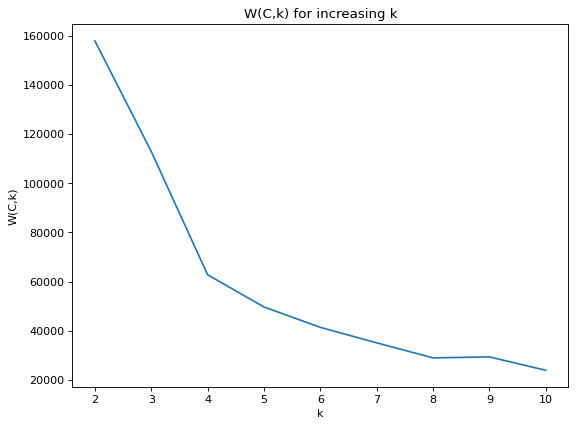

In [885]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('W(C,k) for increasing k')
plt.xlabel('k')
plt.ylabel('W(C,k)')
plt.plot([2,3,4,5,6,7,8,9,10],Warray)

We are seeking to find an optimal $k$, that is to say a hyperparameter that is the smallest possible to effectively cluster the data, whereas that is also minimizing the distances in between the data points inside the clusters (which is minimizing $W(C,k)$). We are thus looking for a $k$ giving the 'elbow’ of the above curve. A such effective $k$ could for instance be here chosen as $k=5$. This optimal $k$ is not equal to the true number of classes (10), which highlights the fact that different clothing here share the same cluster. The two chosen predictors do not provide enough information to distinguish some of the Fashion-MNIST classes, which are located close to each other in this 2-dimensional subspace.   

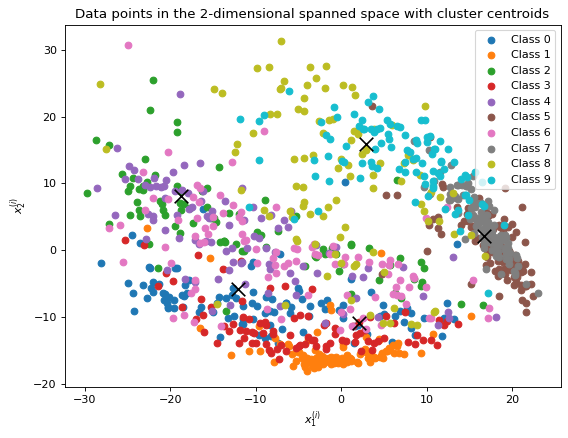

In [893]:
# Computing k-means for k = 5
centroids, labels = kMeans(X = X_pca, k = 5, max_iter = 100, prints = False)

# Plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
classes = y_adapt
for c in np.unique(classes):
    i = np.where(classes == c)
    ax.scatter(x = X_pca[i,0], y = X_pca[i,1], label = 'Class ' + str(int(c)))
ax.legend()

### Coding task 10 ###
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=150)

plt.title('Data points in the 2-dimensional spanned space with cluster centroids')
plt.xlabel('$x^{(i)}_1$')
plt.ylabel('$x^{(i)}_2$')
plt.show()

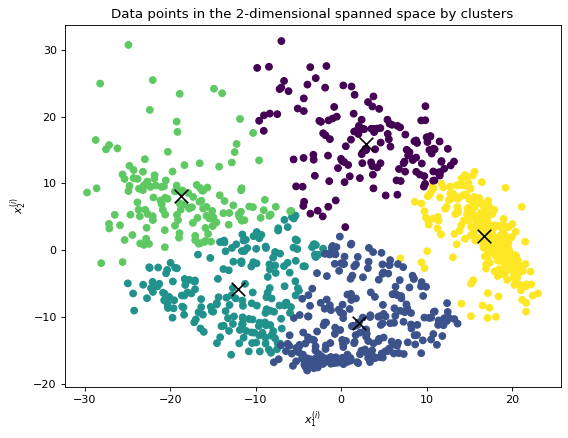

In [1050]:
# With 5 clusters
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Data points in the 2-dimensional spanned space by clusters')
plt.xlabel('$x^{(i)}_1$')
plt.ylabel('$x^{(i)}_2$')
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels);
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=150);

For instance 'brown' and 'grey' true classes are not distinguished here. 

<a name="q22"></a>

## 2.2 Clustering of the feature matrix [^](#outline)

We now investigate the bottlenose dolphins dataset. We are provided with a feature matrix for the 62 data points, each of them made of 32 features.

In [26]:
# Importing the data 
dolphinNames = pd.read_csv('dolphin_names.csv')
A = np.load('dolphins_A_62x62.npy')
F = np.load('dolphins_F_62x32.npy')

### 2.2.1

We perform hierarchical clustering to cluster the feature matrix F, using the average linkage criteria. 

In [27]:
### Using Coding Task 10 solutions ###

def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()   

In [28]:
### Using Coding Task 10 solutions ###

def hierarchical_clustering(points, distances, linkage):
    """
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the highest level of clustering where all columns 
         have the same index value.
     The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
     The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        if (level % 10) == 0:
            print(f'level:{level}')
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)    ## <-- EDIT THIS LINE
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] \
            = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        
    return assignments

In [31]:
# Distances
D = np.sqrt(computeDistances(F)) # We used ||x_i - x_j||^2 previously

In [32]:
# Performing hierarchical clustering
assignments = hierarchical_clustering(points = F, distances = D, linkage = average_linkage)

level:60
level:50
level:40
level:30
level:20
level:10


We report the sequence of clusters obtained.

In [33]:
# Reporting sequence of clusters
for i in reversed(range(62)) :
    print('Level ' + str(i+1) + ':')
    print(assignments[i])
    print('')

Level 62:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]

Level 61:
[ 0.  1.  2.  3. 63.  5.  6.  7.  8.  9. 10. 63. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]

Level 60:
[ 0.  1.  2.  3. 63.  5.  6.  7.  8. 64. 10. 63. 12. 64. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]

Level 59:
[ 0.  1.  2.  3. 63. 65. 65.  7.  8. 64. 10. 63. 12. 64. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.

### 2.2.2

We implement a method to compute the Silhouette Score of our obtained clustering. 

For a given data point $x_i$ and his corresponding cluster $c_{i,l}$, we define $d_1$ as the average distance between said data point and the other points in its cluster : $d_1 = \frac{1}{N_{c_{i,l}}} \sum_{j \in c_{i,l}} ||x_i - x_j||$.

For the data point $x_i$ and its nearest cluster $\check{c}_{i,l}$ (in which $x_i$ is not), we define $d_2$ as the average distance between the data point and the other points in said considered nearest cluster : $d_2 = \frac{1}{N_{\check{c}_{i,l}}} \sum_{j \in \check{c}_{i,l}} ||x_i - x_j||$.

We define the Silhouette Coefficient as : $SC = \frac{d_2-d_1}{\max(d_1,d_2)}$. The Silhouette Score is the mean of the Silhouette Coefficients over all samples. 

We perform this computation using several helper functions.

In [1006]:
def d1(sampleIndex, assignmentsAtLevel, D = D) :
    """
    This function computes the d1 distance used in the Silhouette Score.

    Parameters
    ----------
    sampleIndex : an integer - the considered sample index
    assignmentsAtLevel : an N-dimensional numpy array - the cluster assignments at a given level
    D : an NxN-dimensional numpy array - the euclidean distances square between the points in F
    
    Returns
    -------
    meanDistances : a float number - d1
    """
    
    clusterIndex = assignmentsAtLevel[sampleIndex] # Cluster identification index
    
    nbSamplesInCluster = np.count_nonzero(assignmentsAtLevel == clusterIndex) # Number of samples in same cluster
    
    distances = np.zeros(nbSamplesInCluster) # Container for distances within cluster 
    
    i = -1
    
    for ind, thisCluster in enumerate(assignmentsAtLevel) : # Going through samples
        
        if thisCluster == clusterIndex : # If same cluster
            i += 1
            distances[i] = D[sampleIndex, ind] # Distance matrix
                
    return distances.mean() # Average of distances 

In [1058]:
# Testing d1
d1Test = d1(sampleIndex = 30, assignmentsAtLevel = assignments[10], D = D)
print('d1 for sample number 30, on level 10 :', d1Test)

d1 for sample number 30, on level 10 : 1.5933640897274017


In [1030]:
def d2(sampleIndex, assignmentsAtLevel, D = D, linkage = average_linkage) :
    """
    This function computes the d2 distance used in the Silhouette Score.

    Parameters
    ----------
    sampleIndex : an integer - the considered sample index
    assignmentsAtLevel : an N-dimensional numpy array - the cluster assignments at a given level
    D : an NxN-dimensional numpy array - the euclidean distances square between the points in F
    linkage : a python function - the cluster linkage function
    
    Returns
    -------
    meanDistances : a float number - d2
    """
    
    clusterIndex = assignmentsAtLevel[sampleIndex] # Cluster identification index
    
    #### Computing nearest cluster index ####
    ### Using Coding Task 10 solutions code ###
    ### Modified ###
    cluster_ids = np.unique(assignmentsAtLevel) # All clusters in this level 
    min_d = np.inf
    nearestCluster = -1 # Seeking cluster nearest to clusterIndex
    for i in range(cluster_ids.size):
        cluster_i = cluster_ids[i] # Current considered cluster 
        if cluster_i != clusterIndex :
            # Distance between considered cluster and clusterIndex
            d = linkage(D, assignmentsAtLevel, cluster_i, clusterIndex) 
            if d < min_d: # Looking for cluster nearest to clusterIndex
                min_d = d
                nearestCluster = cluster_i 
                
    # Number of samples in nearest cluster
    nbSamplesInCluster = np.count_nonzero(assignmentsAtLevel == nearestCluster) 
    
    distances = np.zeros(nbSamplesInCluster) # Container for distances 
    
    i = -1
    
    for ind, thisCluster in enumerate(assignmentsAtLevel) : # Going through samples
        
        if thisCluster == nearestCluster : # If same cluster
            i += 1
            distances[i] = D[sampleIndex, ind] # Distance matrix
                
    return distances.mean() # Average of distances 

In [1098]:
# Testing d2
d2Test = d2(sampleIndex = 30, assignmentsAtLevel = assignments[10], D = D, linkage = average_linkage) 
print('d2 for sample number 30, on level 10 :', d2Test)

d2 for sample number 30, on level 10 : 2.3622677326202393


In [1133]:
def silhouetteCoefficient(sampleIndex, assignmentsAtLevel, D = D, linkage = average_linkage) :
    """
    This function computes the Silhouette Coefficient used in the Silhouette Score.

    Parameters
    ----------
    sampleIndex : an integer - the considered sample index
    assignmentsAtLevel : an N-dimensional numpy array - the cluster assignments at a given level
    D : an NxN-dimensional numpy array - the euclidean distances square between the points in F
    linkage : a python function - the cluster linkage function
    
    Returns
    -------
    SC : a float number - the Silhouette Coefficient
    """
    # By definition
    d_1 = d1(sampleIndex = sampleIndex, assignmentsAtLevel = assignmentsAtLevel, D = D) 
    d_2 = d2(sampleIndex = sampleIndex, assignmentsAtLevel = assignmentsAtLevel, D = D, linkage = linkage)
    SC = (d_2-d_1) / np.max([d_1,d_2])
    
    return SC

In [1099]:
# Silhouette Coefficient test
SCTest = silhouetteCoefficient(sampleIndex = 30, assignmentsAtLevel = assignments[10])
print('Silhouette Coefficient for sample number 30, on level 10 :', SCTest)

Silhouette Coefficient for sample number 30, on level 10 : 0.3254938601053344


In [1132]:
def silhouetteScore(assignmentsAtLevel, numberOfSamples = F.shape[0], D = D, linkage = average_linkage) :
    """
    This function computes the Silhouette Score.

    Parameters
    ----------
    assignmentsAtLevel : an N-dimensional numpy array - the cluster assignments at a given level
    numberOfSamples : an integer - the number of samples in F 
    D : an NxN-dimensional numpy array - the euclidean distances square between the points in F
    linkage : a python function - the cluster linkage function
    
    Returns
    -------
    sScore : a float number - the Silhouette Score
    """
    
    sScore = 0
    
    for sampleIndex in range(numberOfSamples) :
        
        sScore += silhouetteCoefficient(sampleIndex = sampleIndex, assignmentsAtLevel = assignmentsAtLevel, \
                                        D = D, linkage = linkage)
        
    sScore /= numberOfSamples
    
    return sScore

In [1123]:
# Silhouette Score test
sScoreTest = silhouetteScore(assignmentsAtLevel = assignments[10])
print('Silhouette Score on level 10 :', sScoreTest)

Silhouette Score on level 10 : 0.3302664661395371


We compute the Silhouette Score for all levels of the previously performed hierarchical clustering. Note that $d_2$ is not well defined for top levels where there exists only one cluster, resulting in $\texttt{nan}$ outputs. 

In [1164]:
# Computing the Silhouette Score 
# for all levels of hierarchical clustering

silhouetteScores = np.zeros(62) # Container for silhouette scores

for i in reversed(range(0,62)) :
    print('Level ' + str(i+1) + ':')
    silhouetteScores[i] = silhouetteScore(assignmentsAtLevel = assignments[i])
    print('Silhouette Score : ', silhouetteScores[i])
    print('')

Level 62:
Silhouette Score :  0.9932718430106813

Level 61:
Silhouette Score :  0.9853625915847762

Level 60:
Silhouette Score :  0.9745901019206686

Level 59:
Silhouette Score :  0.9634599732817757

Level 58:
Silhouette Score :  0.9458552785054917

Level 57:
Silhouette Score :  0.931855528197332

Level 56:
Silhouette Score :  0.9202846491672583

Level 55:
Silhouette Score :  0.9059851931203979

Level 54:
Silhouette Score :  0.891451169997534

Level 53:
Silhouette Score :  0.877374631176515

Level 52:
Silhouette Score :  0.8628868307556151

Level 51:
Silhouette Score :  0.8476263999376341

Level 50:
Silhouette Score :  0.832444686794481

Level 49:
Silhouette Score :  0.8196877626917113

Level 48:
Silhouette Score :  0.8055656728120181

Level 47:
Silhouette Score :  0.7922977572968118

Level 46:
Silhouette Score :  0.7812060450132162

Level 45:
Silhouette Score :  0.7671201603208101

Level 44:
Silhouette Score :  0.7608830153612052

Level 43:
Silhouette Score :  0.7463394170470712

Leve

<ipython-input-1030-b6b72718a71a>:47: RuntimeWarning: Mean of empty slice.
  return distances.mean() # Average of distances
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


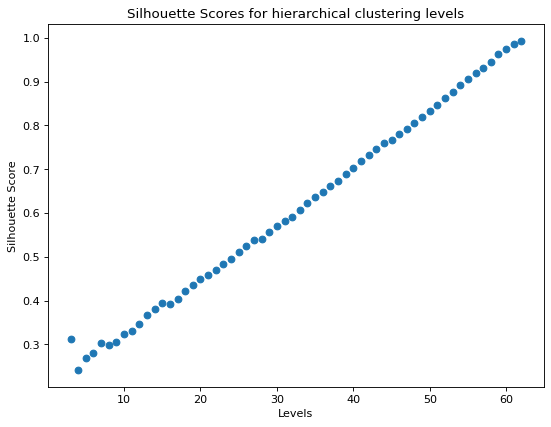

In [1165]:
# Plots
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Silhouette Scores for hierarchical clustering levels')
plt.xlabel('Levels')
plt.ylabel('Silhouette Score')
plt.scatter(x = [i+1 for i in range(62)], y = silhouetteScores)

The optimal levels that maximizes the Silhouette Score are the finest ones. We have that the Silhouette Score varies between -1 and 1. As all samples are in their own cluster for the finest level, we have $d_1 = 0$ and further have all Silhouette Coefficients equal to 1. Not considering said ultimate level, level 61 is the one that  maximizes the Silhouette Score, as the majority of Silhouette Coefficients are also equal to 1, further pushing the mean upwards. 

<a name="q23"></a>

## 2.3 Graph-based analysis  [^](#outline)

We now analyze the graph of frequent associations of the dolphins, given by the adjacency matrix A.

### 2.3.1

We seek to compute the normalized Laplacian of the network, with its two smallest eigenvalues and the corresponding eigenvectors.

In [1166]:
# Adjacency matrix visualization
print('Adjacency matrix')
print(A)

Adjacency matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [1168]:
### Using Coding Task 12 solutions ###
# define diagonal matrix of node degrees
weighted_degree = A.sum(axis=1) 
# create diagonal matrix of degree
D = np.diag(weighted_degree)
# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)
# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)
# define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

We use the $\texttt{numpy}$ eigenvalue computing method for symmetric matrix. The eigenvalues are directly ordered from smallest to largest.

In [1199]:
eigenvalues, eigenvectors = np.linalg.eigh(L_norm)

In [1201]:
# Displaying the two smallest eigenvalues and corresponding eigenvectors
print('Eigenvalue 1 : ' + str(eigenvalues[0]) + ' ≈ 0 ')
print('Eigenvector 1 :')
print(eigenvectors[:, 0])

print('')

print('Eigenvalue 2 : ' + str(eigenvalues[1]))
print('Eigenvector 2 :')
print(eigenvectors[:, 1])

Eigenvalue 1 : -4.370738211750064e-16 ≈ 0 
Eigenvector 1 :
[-0.13736056 -0.15861032 -0.11215443 -0.09712859 -0.05607722 -0.11215443
 -0.13736056 -0.12539247 -0.13736056 -0.14836637 -0.12539247 -0.05607722
 -0.05607722 -0.15861032 -0.19425717 -0.14836637 -0.13736056 -0.16823165
 -0.14836637 -0.11215443 -0.16823165 -0.13736056 -0.05607722 -0.09712859
 -0.13736056 -0.09712859 -0.09712859 -0.12539247 -0.12539247 -0.16823165
 -0.12539247 -0.05607722 -0.09712859 -0.17733173 -0.12539247 -0.05607722
 -0.14836637 -0.18598708 -0.15861032 -0.07930516 -0.15861032 -0.12539247
 -0.13736056 -0.14836637 -0.11215443 -0.18598708 -0.07930516 -0.13736056
 -0.05607722 -0.07930516 -0.14836637 -0.17733173 -0.11215443 -0.07930516
 -0.14836637 -0.07930516 -0.07930516 -0.16823165 -0.05607722 -0.12539247
 -0.05607722 -0.09712859]

Eigenvalue 2 : 0.03952455375743404
Eigenvector 2 :
[ 0.07851822 -0.16036544  0.07295835  0.0618522   0.04448139 -0.20911166
 -0.24277991 -0.08127465  0.07633475 -0.27090905  0.07404428

The Laplacian matrix is positive semi-definite and thus all eigenvalues are to be non-negative. The first eigenvalue we obtain here is immaterially negative, as it is a numerical approximation of zero (order $10^{-16}$). 

Hence, we have only one zero eigenvalue here and further that the corresponding graph is connected.


The spectral connectivity of the graph $\lambda_2$ is rather small (order $10^{-2}$), which will give a cost of splitting the graph into two subgraphs consequently rather low.

We now use the $\mathbf{v}_2$ Fiedler eigenvector to perform the split.

In [1213]:
### Using Coding Task 12 solutions ###
spectral_partition = eigenvectors[:, 1]
spectral_partition[spectral_partition < 0] = 0 
spectral_partition[spectral_partition > 0] = 1 

print('62 nodes subgraph assignment : ')
print(spectral_partition)

62 nodes subgraph assignment : 
[1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.]


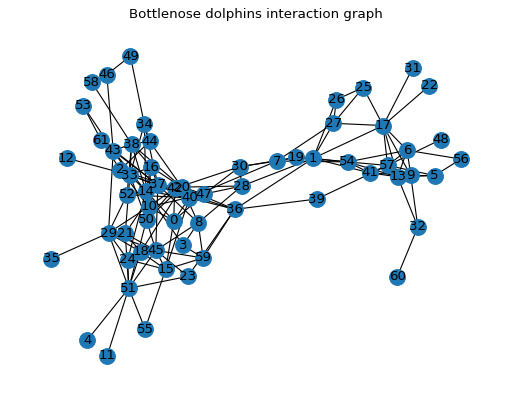

In [64]:
# Building the graph
g = nx.Graph(A)
# Drawing graph
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Bottlenose dolphins interaction graph')
nx.draw(g,node_size = 200, with_labels = True)

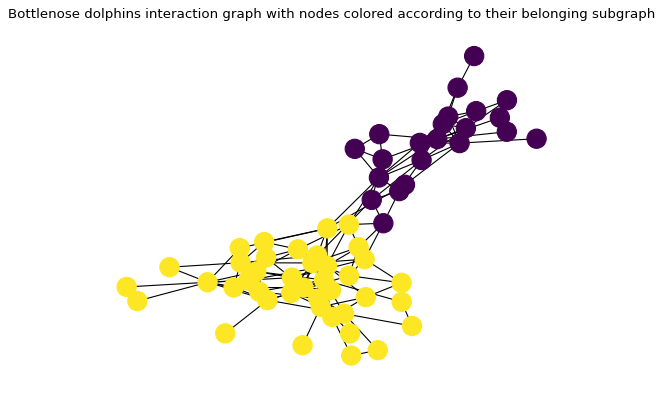

In [1215]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Bottlenose dolphins interaction graph with nodes colored according to their belonging subgraph')
nx.draw(g, node_color = spectral_partition)

### 2.3.2

We now consider centralities in the dolphins interaction graph. For each node, we compute the degree centrality, the eigenvector centrality and the PageRank related centrality. 

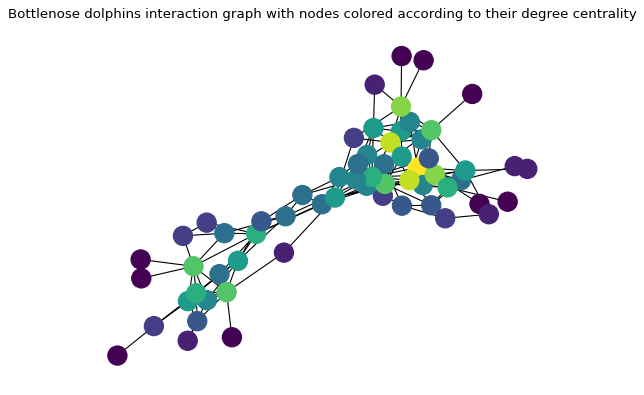

In [1243]:
# Degree centrality

### Using Coding Task 12 solutions ###
# Compute the degree of the adjacency
degree = A.sum(axis=1) 
twoTimesE = np.sum(degree)
degree /= twoTimesE ### Normalizing ###
# Drawing the degree distribution
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Bottlenose dolphins interaction graph with nodes colored according to their degree centrality')
nx.draw(g,node_color = degree)

In [1228]:
# Degree centrality
print('Degree centrality of each node : ')
print(degree)

Degree centrality of each node : 
[0.01886792 0.02515723 0.01257862 0.00943396 0.00314465 0.01257862
 0.01886792 0.01572327 0.01886792 0.02201258 0.01572327 0.00314465
 0.00314465 0.02515723 0.03773585 0.02201258 0.01886792 0.02830189
 0.02201258 0.01257862 0.02830189 0.01886792 0.00314465 0.00943396
 0.01886792 0.00943396 0.00943396 0.01572327 0.01572327 0.02830189
 0.01572327 0.00314465 0.00943396 0.03144654 0.01572327 0.00314465
 0.02201258 0.03459119 0.02515723 0.00628931 0.02515723 0.01572327
 0.01886792 0.02201258 0.01257862 0.03459119 0.00628931 0.01886792
 0.00314465 0.00628931 0.02201258 0.03144654 0.01257862 0.00628931
 0.02201258 0.00628931 0.00628931 0.02830189 0.00314465 0.01572327
 0.00314465 0.00943396]


In [1303]:
# Degree centrality
print('Mean of degree centralities over all nodes : ', degree.mean())
# Index of most three central nodes
ind = np.argpartition(degree, -3)[-3:]
ind = ind[np.argsort(degree[ind])] 

j = 0
for i in reversed(ind) :
    j += 1
    print('Degree centrality | Top ' + str(j) + \
          ' central node is node ' + str(i) + ' with centrality = ' + str(degree[i]))

Mean of degree centralities over all nodes :  0.016129032258064516
Degree centrality | Top 1 central node is node 14 with centrality = 0.03773584905660377
Degree centrality | Top 2 central node is node 37 with centrality = 0.03459119496855346
Degree centrality | Top 3 central node is node 45 with centrality = 0.03459119496855346


According to degree centrality, we observe that the top 3 central nodes are nodes 14, 37 and 45. They are here indeed relatively highly central, with a centrality roughly 2 times higher than the mean. 

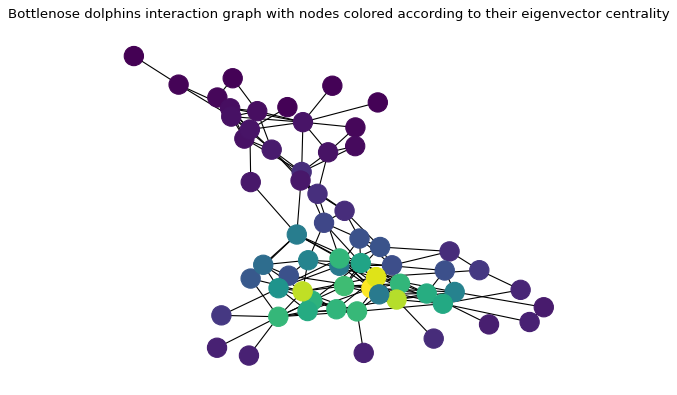

In [1227]:
# Eigenvector centrality

### Using Coding Task 12 solutions ###
# Compute the eigenvector associated with the largest eigenvalue
eigenvalue, eigenvector = linalg.eigsh(A, 1, which="LM", return_eigenvectors=True)
# Drawing the degree distribution
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Bottlenose dolphins interaction graph with nodes colored according to their eigenvector centrality')
nx.draw(g,node_color = eigenvector)

In [1267]:
# Eigenvector centrality
print('Eigenvector centrality of each node : ')
eigenvector = eigenvector.reshape(62,)
print(eigenvector)

Eigenvector centrality of each node : 
[0.12850353 0.04207615 0.03975712 0.07933476 0.02928739 0.00655926
 0.01219126 0.04290099 0.14310214 0.01219738 0.07525347 0.02928739
 0.03907614 0.01500469 0.31578285 0.16417581 0.20799426 0.01751244
 0.20249469 0.02067478 0.18447739 0.2073514  0.00243444 0.08736214
 0.19321357 0.00594605 0.00894396 0.01631719 0.0682235  0.21176308
 0.04074725 0.00243444 0.00385593 0.28109869 0.13882809 0.02943765
 0.1327621  0.30056205 0.19661764 0.02087104 0.20787191 0.01524357
 0.0809501  0.19033934 0.07780237 0.28500522 0.02971651 0.08037062
 0.00241549 0.02342975 0.21769179 0.21068221 0.12956429 0.03368693
 0.02300201 0.05210983 0.00260655 0.01737613 0.02733225 0.11181862
 0.00053602 0.0519914 ]


In [1302]:
# Eigenvector centrality
print('Mean of eigenvector centralities over all nodes : ', eigenvector.mean())
# Index of most three central nodes
ind = np.argpartition(eigenvector, -3)[-3:]
ind = ind[np.argsort(eigenvector[ind])] 

j = 0
for i in reversed(ind) :
    j += 1
    print('Eigenvector centrality | Top ' + str(j) + \
          ' central node is node ' + str(i) + ' with centrality = ' + str(eigenvector[i]))

Mean of eigenvector centralities over all nodes :  0.09077350090844759
Eigenvector centrality | Top 1 central node is node 14 with centrality = 0.3157828494923705
Eigenvector centrality | Top 2 central node is node 37 with centrality = 0.30056205467754865
Eigenvector centrality | Top 3 central node is node 45 with centrality = 0.2850052152846936


According to eigenvector centrality, we observe that the top 3 central nodes are the same as previously : 14, 37 and 45. They are also relatively highly central here, with a centrality roughly 3 times higher than the mean. 

In [1250]:
# PageRank centrality 

def pageRank(A, D, alpha = 0.85) :
    """
    This function computes the PageRank related centralities of the nodes in the graph given by the
    adjacency matrix A.

    Parameters
    ----------
    A : an (NxN)-dimensional numpy array - the graph's adjacency matrix
    A : an (NxN)-dimensional numpy array - the diagonal matrix filled with the degrees of each node
    alpha : a float number - a probability parameter of the PageRank algorithm, customarily defaulted to 0.85
    
    Returns
    -------
    c : an N-dimensional numpy array - the centrality value of each nodes  
    """

    N = A.shape[0] # Number of nodes
    I = np.identity(N) # Identity
    ones = np.ones((N,1)) # Filled with ones
    c = np.linalg.solve(I  - alpha * (A@np.linalg.inv(D)), ((1 - alpha) / N) * ones) # Solving system
    
    return c.reshape(N,)

In [1252]:
pageRankCentralities = pageRank(A = A, D = D, alpha = 0.85) 

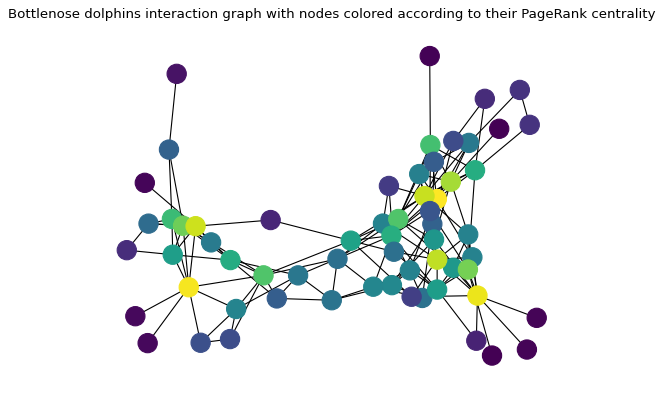

In [1254]:
# PageRank centrality 

# Drawing the degree distribution
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Bottlenose dolphins interaction graph with nodes colored according to their PageRank centrality')
nx.draw(g,node_color = pageRankCentralities)

In [1255]:
# PageRank centrality 
print('PageRank centrality of each node : ')
print(pageRankCentralities)

PageRank centrality of each node : 
[0.01696539 0.02465072 0.01333808 0.00962906 0.0050798  0.01442805
 0.02005363 0.01564303 0.0170983  0.02345848 0.0151084  0.0050798
 0.00483532 0.02615688 0.03214449 0.01988308 0.01662682 0.03172814
 0.01939555 0.0129282  0.02464092 0.01693899 0.0054159  0.0098635
 0.01690576 0.01150422 0.01121014 0.01713009 0.01484574 0.02645855
 0.0153021  0.0054159  0.01330868 0.02842307 0.01591994 0.00491822
 0.02061339 0.02987534 0.02393924 0.00776475 0.02196637 0.01613757
 0.01761865 0.02169113 0.01283083 0.0295142  0.0088259  0.01733952
 0.0052617  0.00887675 0.01923194 0.03129936 0.01207259 0.00818105
 0.02165088 0.00749417 0.00832625 0.03009537 0.0049629  0.01476792
 0.00619015 0.01103919]


In [1301]:
# PageRank centrality
print('Mean of PageRank centralities over all nodes : ', pageRankCentralities.mean())
# Index of most three central nodes
ind = np.argpartition(pageRankCentralities, -3)[-3:]
ind = ind[np.argsort(pageRankCentralities[ind])] 

j = 0
for i in reversed(ind) :
    j += 1
    print('PageRank centrality | Top ' + str(j) + \
          ' central node is node ' + str(i) + ' with centrality = ' + str(pageRankCentralities[i]))

Mean of PageRank centralities over all nodes :  0.016129032258064516
PageRank centrality | Top 1 central node is node 14 with centrality = 0.032144492779242834
PageRank centrality | Top 2 central node is node 17 with centrality = 0.03172814041038732
PageRank centrality | Top 3 central node is node 51 with centrality = 0.031299356904643215


According to PageRank centrality, we observe that the top 3 central nodes are not the same as previously, whereas the top 1 node is actually the same (node 15). The top three nodes are here : 14, 37 and 45. They are also relatively highly central, with a centrality roughly 2 times higher than the mean. 

We now compute 3 correlation plots to compare the different centrality measures.

Degree centrality VS Eigenvector centrality | Correlation coefficient R =  0.7196477408935358


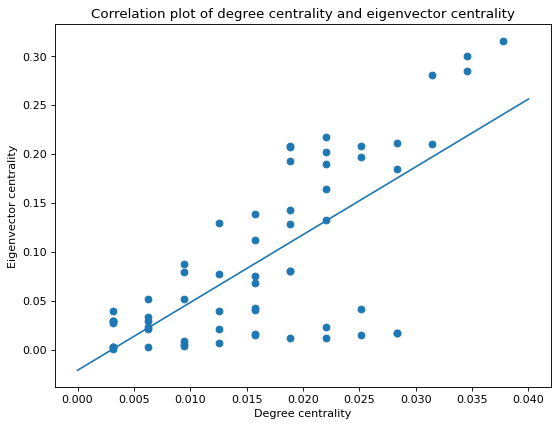

In [1328]:
# Comparing degree centrality and eigenvector centrality

res = scipy.stats.linregress(x = degree, y = eigenvector)
a = res[0]
b = res[1]
R = res[2]

plt.figure(figsize=(8, 6), dpi=80)
plt.title('Correlation plot of degree centrality and eigenvector centrality')
plt.scatter(degree, eigenvector)
iden = np.linspace(start = 0, stop = 0.04, num = 50)
plt.xlabel('Degree centrality')
plt.ylabel('Eigenvector centrality')
plt.plot(iden, a * iden + b)

print('Degree centrality VS Eigenvector centrality | Correlation coefficient R = ', R)

Eigenvector centrality  VS PageRank centrality| Correlation coefficient R =  0.6094173321392826


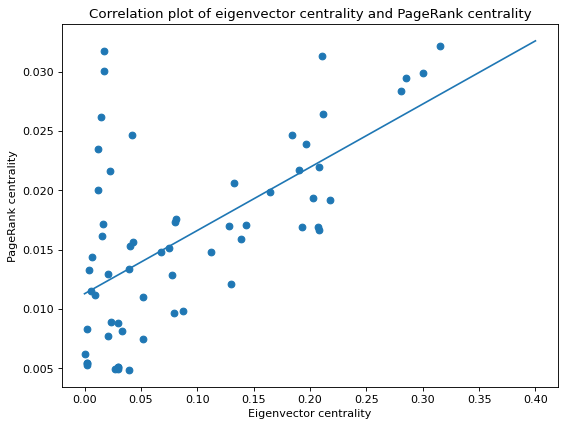

In [1329]:
# Comparing eigenvector centrality and PageRank centrality

res = scipy.stats.linregress(x = eigenvector, y = pageRankCentralities)
a = res[0]
b = res[1]
R = res[2]

plt.figure(figsize=(8, 6), dpi=80)
plt.title('Correlation plot of eigenvector centrality and PageRank centrality')
plt.scatter(eigenvector, pageRankCentralities)
iden = np.linspace(start = 0, stop = 0.4, num = 50)
plt.xlabel('Eigenvector centrality')
plt.ylabel('PageRank centrality')
plt.plot(iden, a * iden + b)

print('Eigenvector centrality  VS PageRank centrality| Correlation coefficient R = ', R)

Degree centrality  VS PageRank centrality| Correlation coefficient R =  0.9830947647309217


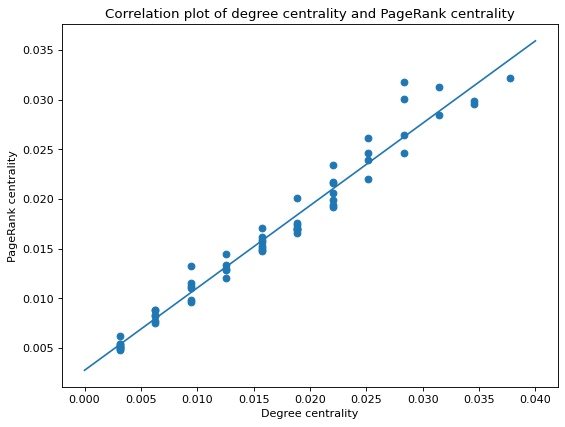

In [1330]:
# Comparing degree centrality and PageRank centrality

res = scipy.stats.linregress(x = degree, y = pageRankCentralities)
a = res[0]
b = res[1]
R = res[2]

plt.figure(figsize=(8, 6), dpi=80)
plt.title('Correlation plot of degree centrality and PageRank centrality')
plt.scatter(degree, pageRankCentralities)
iden = np.linspace(start = 0, stop = 0.04, num = 50)
plt.xlabel('Degree centrality')
plt.ylabel('PageRank centrality')
plt.plot(iden, a * iden + b)

print('Degree centrality  VS PageRank centrality| Correlation coefficient R = ', R)

We observe that degree centralities and eigenvector centralities do not correlate very well ($R \approx 71\%$), as a sizeable specific subset of nodes do not have close pairs of centralities (under the line). As well, eigenvector centralities and PageRank centralities do not correlate well ($R \approx 61\%$). The correlation coefficient is rather low as an important subset of nodes have a small eigenvector centrality for a large PageRank centrality. However, degree centralities and PageRank centralities correlate well ($R \approx 98\%$), all nodes having close pairs of centrality values in this setting. 

The differences between degree centralities and eigenvector centralities and eigenvector centralities and PageRank centralities might arise from the fact that some high degree nodes may be connected in majority to 'uncentral' neighbors.

In [1318]:
# Useful names
print('Dolphin corresponding to node 14 is named : ' + dolphinNames.to_numpy()[14][1])
print('Dolphin corresponding to node 17 is named : ' + dolphinNames.to_numpy()[17][1])
print('Dolphin corresponding to node 37 is named : ' + dolphinNames.to_numpy()[37][1])
print('Dolphin corresponding to node 45 is named : ' + dolphinNames.to_numpy()[45][1])
print('Dolphin corresponding to node 51 is named : ' + dolphinNames.to_numpy()[51][1])

Dolphin corresponding to node 14 is named : Grin
Dolphin corresponding to node 17 is named : Jet
Dolphin corresponding to node 37 is named : SN4
Dolphin corresponding to node 45 is named : Topless
Dolphin corresponding to node 51 is named : Trigger


In the paper by $\textit{Lusseau et al}$, the marine biologists identify Trigger and Topless as some of the most central dolphins. Topless corresponds to node 45, which was the third biggest degree and eigenvector centrality, and is identified by the biologists as one of two $\textit{central individuals}$ in a dolphin sub-group composed of six males and one female. Trigger corresponds to node 51 which was the third biggest PageRank centrality, and is described by the scientists as having $\textit{a central position between}$ two sub-groups. Furthermore, it is also stated that $\textit{Trigger only had significant associations with members of the Jonah/Topless network}$.

Grin which corresponds to node 14 - that has been computed as the maximum degree, eigenvector and PageRank centrality - is not specifically stated by the authors. On the paper's $\textit{figure 2}$ sociogram, we can identify Grin as a rather central individual of one of the sub-groups, in particular having an outer sub-group relationship that connects it's component to the others. Therein, it's computed centrality could be significantly pulled up. Finally, SN4 and Jet are not stated explicitly by the authors and can be identified as simple connected members of their respective sub-groups. 

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

We here perform Non-Negative Matrix Factorization (NMF) for dimensionality reduction on the previously used Fashion-MNIST image dataset. We also continue to study the social network made of the observed interactions between the bottlenose dolphins. In particular, we perform community detection on said dataset.

<a name="q31"></a>

## 3.1 Non-Negative Matrix Factorization (NMF) for dimensionality reduction  [^](#outline)

We again consider the first 1000 images of the Fashion-MNIST dataset.

### 3.1.1

We here perform dimensionality reduction by using NMF. 

In [1319]:
### Using this code from Coding Task 11 ###

def normalize_nmf(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X)) 
    return X_norm

In [1343]:
# Normalizing
x_nmf = normalize_nmf(x_bar)

In [1344]:
### Using this code from Coding Task 11 ###

def cost(X,W,H):
    # lets define a cost matrix to compare the difference
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) 
    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])
    
    return chi2

In [1375]:
### Using this code from Coding Task 11 ###

def NMF(X, m = 10, numIters = 500) :
    """
    This function computes the Non-Negative Matrix Factorization of data matrix X (X ≈ WH), by using 
    Lee and Seung's multiplicative update rule.

    Parameters
    ----------
    X : an (Nxp)-dimensional numpy array - the data matrix
    m : an integer - the dimensions onto which to project the data
    numIters : an integer - the number of iterations for the update process 
    
    Returns
    -------
    W : an (Nxm)-dimensional numpy array - components matrix
    H : an (mxp)-dimensional numpy array - components matrix
    chi2 : an numIters-dimensional numpy array - the chi2 cost computed at each step
    """
    
    ### Initialization ###
    # N x m components matrix, usually interpreted as the coefficients, where N is the number of data
    W = np.random.rand(X.shape[0], m) ### Randomly initialized ###
    # m x p matrix interpreted as the basis set, where p is the number of features (e.g. pixels)
    H = np.random.rand(m, X.shape[1])
    # empty list for chi2 
    chi2 = [] ### Error ###

    for i in range(numIters):

        # compute the update on H
        H = H * ((W.T.dot(X)) / W.T.dot(W.dot(H))) 

        # compute the update on W
        W = W * ((X.dot(H.T)) / (W.dot(H.dot(H.T))))

        # compute the chi2 and append to list
        chi2.append(cost(X,W,H))
    
    
    return W, H , chi2

In [1376]:
# Performing NMF
W, H, chi2 = NMF(X = x_nmf, m = 10, numIters = 500)

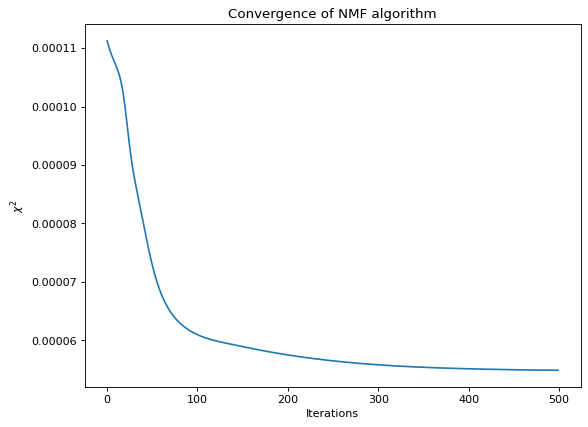

In [1348]:
# Plot of the convergence
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Convergence of NMF algorithm')
plt.plot(chi2)
plt.xlabel('Iterations')
plt.ylabel('$\chi^2$')
plt.show()

### 3.1.2


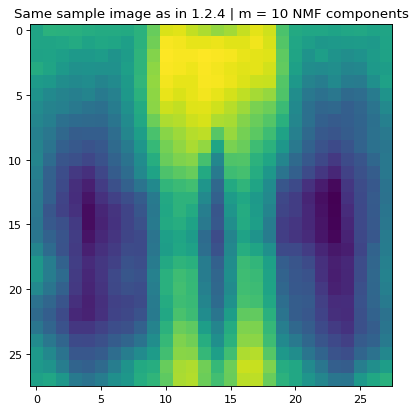

In [1377]:
# m = 10 NMF components
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Same sample image as in 1.2.4 | m = 10 NMF components')
plt.imshow((W @ H)[16,:].reshape([28,28])) # Taking the same sample image from the testing set as in 1.2.4

In [1359]:
# Computing PCA with m = 10
X_pca, eigenvectors, eigenvalues = pca_function(X = x_bar,k = 10)
print('X_PCA for m = 10 : ')
print(X_pca)

X_PCA for m = 10 : 
[[  1.46121129  20.42441892   2.80783889 ...  -4.1392189   -1.11588562
   -3.00868602]
 [-17.74664625  -4.43726285   4.70397008 ...  -4.33975389  -2.23252072
    0.93941758]
 [  8.58548541 -12.72625069   2.90980387 ...  -0.64610897  -0.71465531
   -0.14232542]
 ...
 [ 11.97145273 -11.2134249    6.1370557  ...  -0.8516102    0.1969147
    0.43548128]
 [  5.44715192  17.40473124   8.3085195  ...  -9.76503107   1.7201901
   -0.26757223]
 [  1.52337351  17.75829829  -3.93460432 ...  -5.43796515  -6.31830248
    3.38596262]]


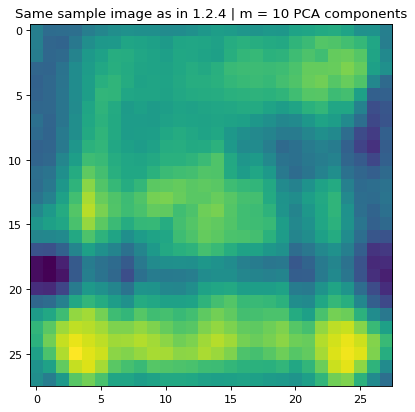

In [1379]:
# m = 10 PCA components
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Same sample image as in 1.2.4 | m = 10 PCA components')
plt.imshow((X_pca @ H)[16,:].reshape([28,28])) 

<a name="q32"></a>

## 3.2 Community detection [^](#outline)

We finally go back to the bottlenose dolphins social network, to perform community detection.

### 3.2.1

We seek to find the optimal communities in the dolphin interactions graph, using Louvain algorithm.

In [9]:
# Computing communities using Louvain algorithm
communities = nx.algorithms.community.louvain_communities(g)

In [11]:
# Optimal community structure 
print('Five communities computed : ')
print(communities)

Five communities computed : 
[{35, 4, 11, 45, 15, 18, 51, 21, 55, 23, 24, 29}, {1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60}, {3, 36, 39, 8, 59, 28}, {12, 14, 16, 20, 33, 34, 37, 38, 40, 43, 44, 46, 49, 50, 52, 53, 58, 61}, {0, 2, 7, 10, 42, 47, 19, 30}]


In [13]:
# Serializing communities
colorCommunity = np.zeros(62)
for n in range(62) :
    if n in communities[0] :
        colorCommunity[n] = 0
    elif n in communities[1] :
        colorCommunity[n] = 1
    elif n in communities[2] :
        colorCommunity[n] = 2
    elif n in communities[3] :
        colorCommunity[n] = 3
    elif n in communities[4] :
        colorCommunity[n] = 4
    else :
        raise ValueError('Node ' + str(n) + ' not in a community')

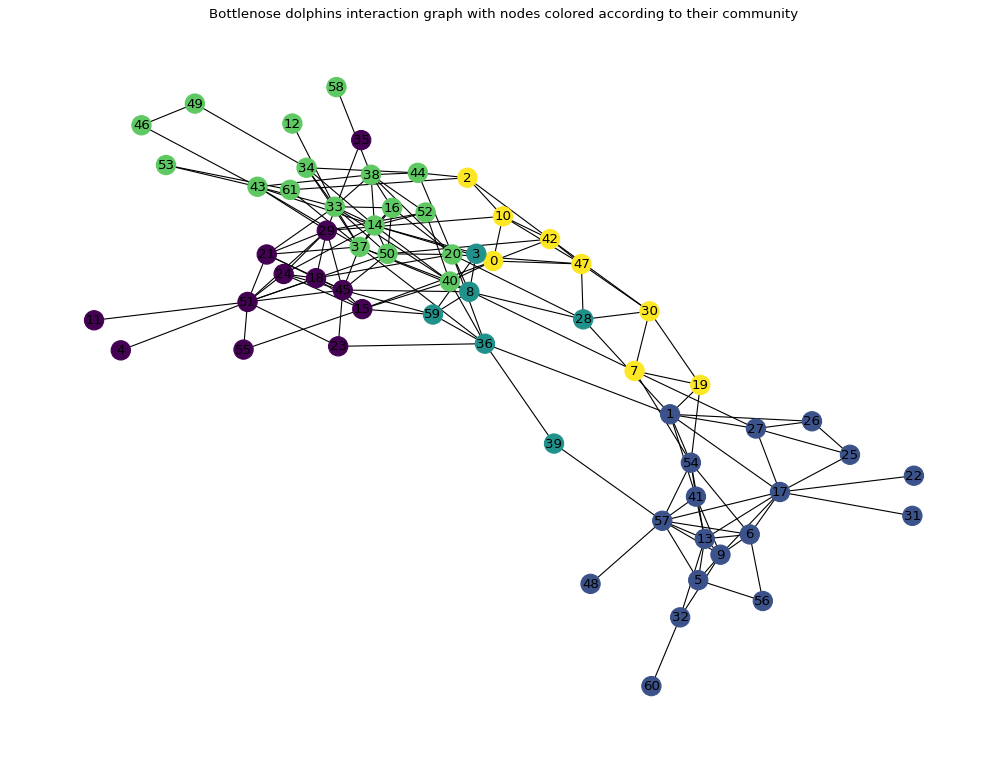

In [16]:
# Drawing the degree distribution
plt.figure(figsize=(16, 12), dpi=80)
plt.title('Bottlenose dolphins interaction graph with nodes colored according to their community')
nx.draw(g,node_color = colorCommunity, with_labels = True)

According to the different centrality measure we used in 2.3.2, the top central nodes were 14, 17, 37, 45, 51. In this community structure, we observe that node 14 and 37 share the same community (green color), being 'visually' highly central in the corresponding subgroup. Node 17 remains alone in the dark blue community, having a clear central position in his group. The nodes 45 and 51 also share and occupy a central place in the purple community. We further have that highly central nodes sharing a community (14 and 37, 45 and 51) are directly connected to each other. Moreover, note that node 14 - that has been computed as the most central node for all measures - has a central position in the green community, which is itself 'a central community among communities'. Indeed, the green group plays a linking role between the more outer purple community and the yellow and turquoise ones. Finally, the central node 17 may be the only one is his community, as his dark blue group is exterior in the sociogram.

### 3.2.2

We use Adjusted Rand Index (ARI) to compare the clustering made with Louvain algorithm and the one performed by hierarchical clustering in 2.2.

In [20]:
# Louvain communities
print('Louvain communities : ')
print(colorCommunity)

Louvain communities : 
[4. 1. 4. 2. 0. 1. 1. 4. 2. 1. 4. 0. 3. 1. 3. 0. 3. 1. 0. 4. 3. 0. 1. 0.
 0. 1. 1. 1. 2. 0. 4. 1. 1. 3. 3. 0. 2. 3. 3. 2. 3. 1. 4. 3. 3. 0. 3. 4.
 1. 3. 3. 0. 3. 3. 1. 0. 1. 1. 3. 2. 1. 3.]


In [48]:
# Hierarchical Clustering 
print('Hierarchical clustering (level 10) : ')
hierarchicalClustering = assignments[9]
print(hierarchicalClustering)

Hierarchical clustering (level 10) : 
[113. 112. 113.  94. 109. 111. 111. 112.  94. 111. 113. 109. 114. 111.
 114. 109. 114. 112. 109. 112. 113. 109. 112. 101. 109. 112. 112. 112.
 113. 109. 113. 112. 111. 114. 104. 109. 101. 114. 114. 101. 114. 111.
 113. 104. 114. 109. 104. 113. 111. 104. 114. 109. 114.  90. 112. 109.
 111. 111. 114.  94. 111.  90.]


In [59]:
# Investigating ARI
for lvl in range(62) :
    hierarchicalClustering = assignments[lvl]
    ARI = adjusted_rand_score(colorCommunity, hierarchicalClustering)
    print('')
    print('Number of clusters / Level of hierarchical clustering = ', lvl)
    print('ARI between Louvain communities clustering and hierarchical clustering : ', ARI)


Number of clusters / Level of hierarchical clustering =  0
ARI between Louvain communities clustering and hierarchical clustering :  0.0

Number of clusters / Level of hierarchical clustering =  1
ARI between Louvain communities clustering and hierarchical clustering :  0.0

Number of clusters / Level of hierarchical clustering =  2
ARI between Louvain communities clustering and hierarchical clustering :  0.3430834433405128

Number of clusters / Level of hierarchical clustering =  3
ARI between Louvain communities clustering and hierarchical clustering :  0.6802548878464489

Number of clusters / Level of hierarchical clustering =  4
ARI between Louvain communities clustering and hierarchical clustering :  0.7927321782386915

Number of clusters / Level of hierarchical clustering =  5
ARI between Louvain communities clustering and hierarchical clustering :  0.7429788069844637

Number of clusters / Level of hierarchical clustering =  6
ARI between Louvain communities clustering and hiera

In [56]:
# The level with best similarity is level 7
print('Hierarchical clustering with best similarity (level 7) : ')
hierarchicalClustering = assignments[6]
print(hierarchicalClustering)
print('')
print('ARI = ', adjusted_rand_score(colorCommunity, hierarchicalClustering))
print('')
print('Number of clusters : ', np.unique(hierarchicalClustering).shape[0])

Hierarchical clustering with best similarity (level 7) : 
[113. 117. 113. 115. 109. 117. 117. 117. 115. 117. 113. 109. 116. 117.
 116. 109. 116. 117. 109. 117. 113. 109. 117. 115. 109. 117. 117. 117.
 113. 109. 113. 117. 117. 116. 116. 109. 115. 116. 116. 115. 116. 117.
 113. 116. 116. 109. 116. 113. 117. 116. 116. 109. 116.  90. 117. 109.
 117. 117. 116. 115. 117.  90.]

ARI =  0.7971905530350457

Number of clusters :  6


The ARI score is maximum when comparing the Louvain similarity and the hierarchical clustering at level 7 (ARI = 0.79). The $\textit{homophily principle in social networks}$ states that 'similar' individuals tend to interact more with each other than with other members. Hence, we observe the genesis of sub-groups of individual which preferentially interact with each other. Unsurprisingly, the ARI score is the largest for a number of cluster close to what was given by the Louvain algorithm (4, 5 and 6 clusters giving the largest ARI values as we had 5 Louvain communities).